## NO LATENCY
### Assumption: I can submit bid-ask quotes AFTER I see the current bidPrice and askPrice

In [201]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from time import perf_counter
from scipy.linalg import expm, inv, eig

Loading noise trades and week1 results

In [204]:
# Structuring the data

MM_train = pd.read_csv('noise_trades__train.csv', index_col = 0)
week1 = pd.read_csv('sample_data_20200909_2_train.csv', index_col = 0)
MM_train['trade'] = 0
MM_train['trade'] = -1*(MM_train['side'] == 'SELL') + 1*(MM_train['side'] == 'BUY')
MM_train['qty'].fillna(0,inplace= True)
week1['trade'] = MM_train['trade'] * MM_train['qty']
week1['midPrice'] = (week1['bidPrice'] + week1['offerPrice'])/2
week1.iloc[30:45]

,bidPrice,offerPrice,bidQty,offerQty,nextBid,nextOffer,trade,midPrice
time,,,,,,,,
30,109.65,110.15,89,71,109.70,110.10,0.0,109.9
31,109.70,110.10,54,77,109.75,110.05,0.0,109.9
32,109.75,110.05,65,61,109.65,110.15,0.0,109.9
33,109.65,110.15,52,57,109.75,110.05,0.0,109.9
34,109.75,110.05,88,65,109.85,109.95,39.0,109.9
35,109.85,109.95,58,51,109.75,110.05,0.0,109.9
36,109.75,110.05,76,84,109.75,110.05,0.0,109.9
37,109.75,110.05,51,58,109.75,110.05,0.0,109.9
38,109.75,110.05,97,70,109.80,110.00,0.0,109.9


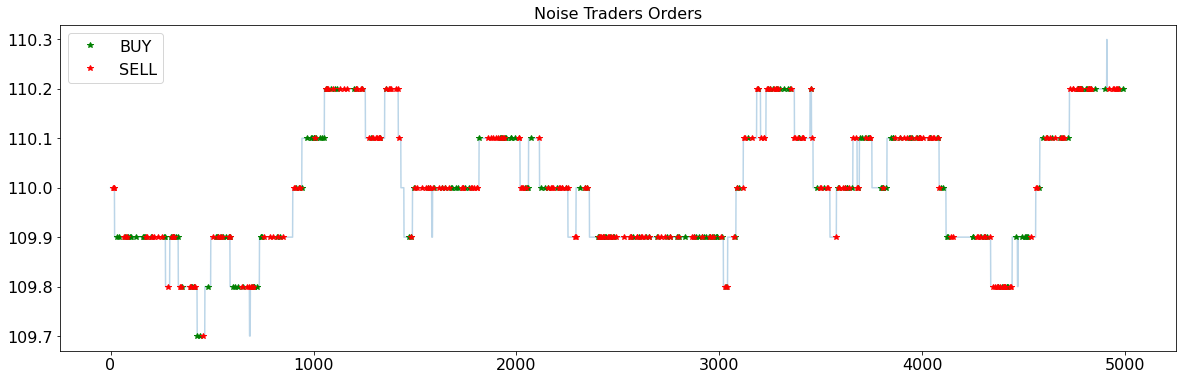

In [205]:
# Building a plot for Noise Trader Orders

plt.figure(figsize = (20,6))
start_time = 0
end_time =  5000
plt.plot(week1['midPrice'][start_time:end_time],alpha=0.3)
plt.plot(week1[week1['trade'] > 0]['midPrice'].loc[start_time:end_time],'*',color = 'g', label='BUY')
plt.plot(week1[week1['trade'] < 0]['midPrice'].loc[start_time:end_time],'*',color = 'r',label='SELL')
plt.legend()
plt.title('Noise Traders Orders')
plt.show();

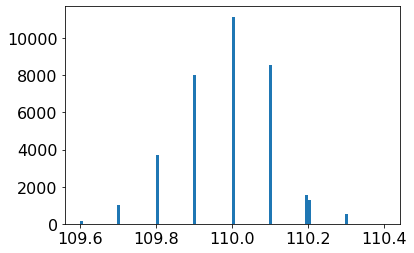

In [206]:
# Looking at the midPrice distribution
plt.hist(week1['midPrice'], bins = 100)
plt.show()

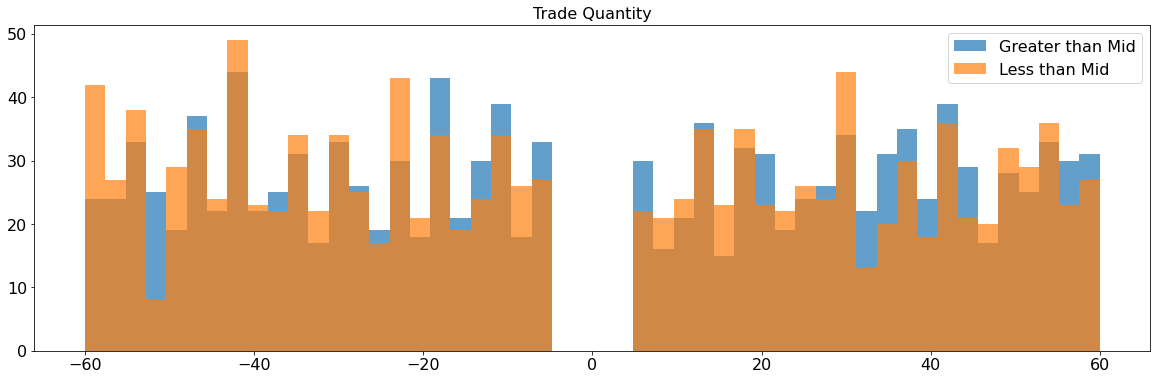

In [207]:
# Looking at the trade quantity requested by the noise traders

plt.figure(figsize=(20,6))
plt.hist(week1[(week1['trade'] != 0) & (week1['midPrice'] > 110)]['trade'] \
         , bins = 50, label = 'Greater than Mid', alpha = 0.7)
plt.hist(week1[(week1['trade'] != 0) & (week1['midPrice'] < 110)]['trade'] \
         , bins = 50, label = 'Less than Mid', alpha = 0.7)
plt.legend()
# plt.hist(week1[week1['trade'] < 0]['trade'], bins = 50)
plt.title('Trade Quantity')
plt.show();

Distribution seems pretty much same both side of the mid.

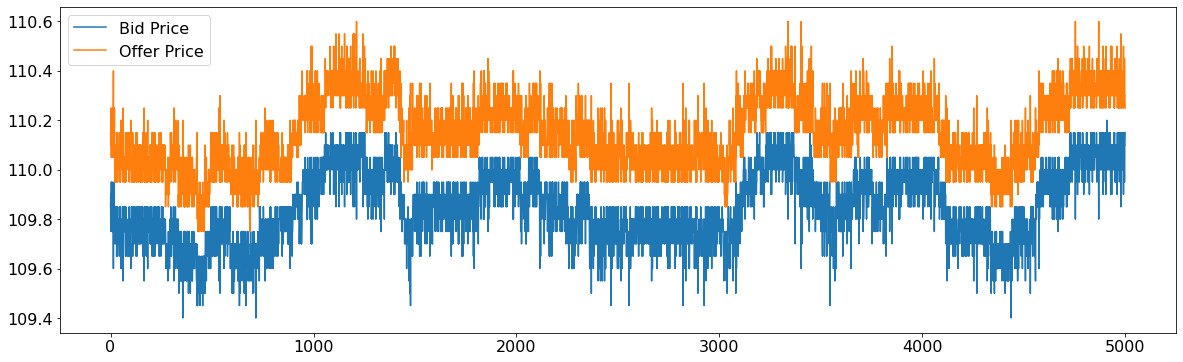

In [208]:
# Looking at the market

plt.figure(figsize=(20,6))
plt.plot(week1['bidPrice'][start_time:end_time],label = 'Bid Price')
plt.plot(week1['offerPrice'][start_time:end_time], label = 'Offer Price')
plt.legend()
plt.show()

In [209]:
# Looking at the ticksize
np.array(sorted(week1['bidPrice'].unique()))

array([109.25, 109.3 , 109.35, 109.4 , 109.45, 109.5 , 109.55, 109.6 ,
       109.65, 109.7 , 109.75, 109.8 , 109.85, 109.9 , 109.95, 110.  ,
       110.05, 110.1 , 110.15, 110.2 , 110.25, 110.3 , 110.35])

#### Bid and Offer are moving in timesteps of 0.05

About 10% of the time the traders ask for a quote. 

# P&L Calculator for Market Making

In [210]:
def PnL_for_MM(data, bid, ask, clear):
    unr_pnl = 0
    pnls = []
    pnl = 0
    inventory = 0
    inventory_price = 0
    cash = 0
    count = 0
    inventory_record = []
    for i in range(len(data)):
        inventory_record.append(inventory)
        if clear[i]:
            if np.sign(inventory) > 0:
                pnl += inventory * (data['bidPrice'].iloc[i] - inventory_price)
                cash += inventory * data['bidPrice'].iloc[i]
            else:
                pnl += inventory * (data['offerPrice'].iloc[i] - inventory_price)
                cash -= abs(inventory) * data['offerPrice'].iloc[i]
            inventory_price = 0
            inventory = 0
            pnls.append(pnl)
            continue
        if data['trade'].iloc[i] > 0 :
            hit = (ask[i] < data['offerPrice'].iloc[i])
        else:
            hit = (bid[i] > data['bidPrice'].iloc[i])
        if hit:
            count += 1
            new_inventory = np.clip(inventory - data['trade'].iloc[i], -100, 100)
#             new_inventory = inventory - data['trade'].iloc[i]
            amount_traded = new_inventory - inventory
            if inventory > 0:
                if amount_traded > 0:
                    inventory_price = (inventory_price * inventory + amount_traded * bid[i]) / new_inventory
                    inventory = new_inventory
                    cash -= amount_traded * bid[i]
                else:
                    if inventory > abs(amount_traded):
                        pnl += abs(amount_traded) * (ask[i] - inventory_price)
                        inventory = new_inventory
                        cash += abs(amount_traded) * ask[i]
                    else:
                        pnl += inventory * (ask[i] - inventory_price)
                        inventory_price = ask[i]
                        inventory = new_inventory
                        cash += abs(amount_traded) * ask[i]
            else:
                if amount_traded < 0:
                    inventory_price = (inventory_price * inventory + amount_traded * ask[i]) / new_inventory
                    inventory = new_inventory
                    cash += abs(amount_traded) * ask[i]
                else:
                    if abs(inventory) > amount_traded:
                        pnl += amount_traded * (inventory_price - bid[i])
                        inventory = new_inventory
                        cash -= amount_traded * bid[i]
                    else:
                        pnl += abs(inventory) * (inventory_price - bid[i])
                        inventory_price = bid[i]
                        inventory = new_inventory
                        cash -= amount_traded * bid[i]
#             print("At {}, traded amount: {}, now unr_pnl: {}, now pnl: {}, now inventory: {}".format(i, amount_traded, unr_pnl, pnl, inventory))
        pnls.append(pnl)
    
#     clear inventory:
    b, a = data_['bidPrice'].iloc[-1], data_['offerPrice'].iloc[-1]
    if inventory > 0:
        cash_earned = cash + b * inventory
        pnl += (data_['bidPrice'].iloc[-1] - inventory_price) * inventory
    else:
        cash_earned = cash + a * inventory
        pnl += (inventory_price  - data_['offerPrice'].iloc[-1]) * inventory
    pnls.append(pnl)
    return pnls, cash_earned, count / len(data), inventory_record

In [212]:
# Structuring the data

MM_train = pd.read_csv('noise_trades__train.csv', index_col = 0)
theta = 0.1
sigma = 0.1
path = 'sample_data_20200909_2_train.csv'
week1 = pd.read_csv(path, index_col = 0)
MM_train['trade'] = 0
MM_train['trade'] = -1*(MM_train['side'] == 'SELL') + 1*(MM_train['side'] == 'BUY')
MM_train['qty'].fillna(0,inplace= True)
week1['trade'] = MM_train['trade'] * MM_train['qty']
week1['midPrice'] = (week1['bidPrice'] + week1['offerPrice'])/2

data_ = week1.loc[week1['trade']!=0, :].copy()
data_.head()

,bidPrice,offerPrice,bidQty,offerQty,trade,midPrice
time,,,,,,
14,109.60,110.40,76,61,-37.0,110.0
15,109.90,110.10,63,79,-44.0,110.0
16,109.90,110.10,92,65,-12.0,110.0
34,109.75,110.05,88,65,39.0,109.9
43,109.65,110.15,67,75,53.0,109.9


# Human Trading : Setting a benchmark for the Reinforcement Learning agent
## As a market maker, I post bid-ask with constant distance from mid price I observe

----------------------------
P&L in total is 4439.69999999977
Standard deviation of P&L is 2.1493828409078124
4439.6999999997615
----------------------------


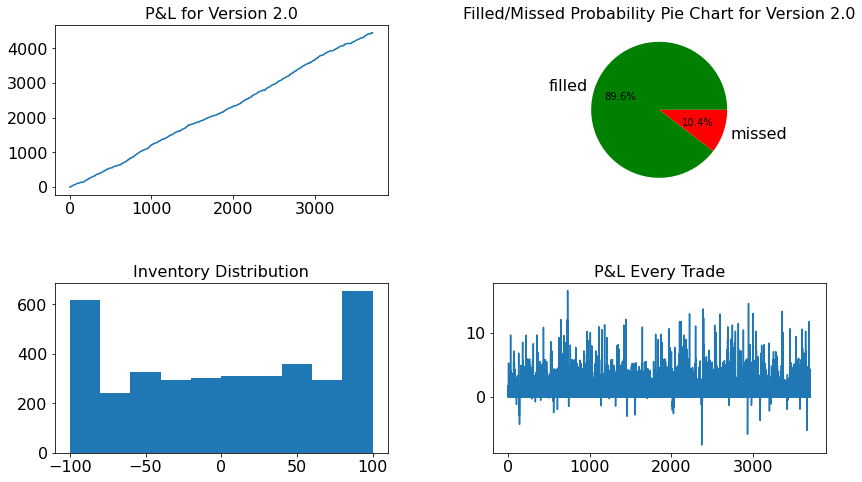

In [215]:
# specifying the bid spread and ask spread
bid_spread = 0.05
ask_spread = 0.05

# Obtaining the performance results for this naive benchmark model
bids = list(data_['midPrice']-bid_spread)
asks = list(data_['midPrice']+ask_spread)
clear = [False]*len(bids)
pnls, true_pnl, hit_prob, inventory_record = PnL_for_MM(data_, bids, asks, clear)

fig, axs = plt.subplots(2, 2,figsize=(13,8))
fig.tight_layout(pad=6.0)

axs[0][0].plot(pnls)
axs[0][0].set_title("P&L for Version 2.0")
axs[0][1].pie([hit_prob*100, 100-hit_prob*100], labels=['filled', 'missed'],autopct='%1.1f%%', colors=['green', 'red'])
axs[0][1].set_title('Filled/Missed Probability Pie Chart for Version 2.0')
axs[1][0].hist(inventory_record)
axs[1][0].set_title("Inventory Distribution")
axs[1][1].plot(np.diff(pnls)[:-1])
axs[1][1].set_title('P&L Every Trade')

print("----------------------------")
print("P&L in total is {}".format(pnls[-1]))
print("Standard deviation of P&L is {}".format(np.std(np.diff(pnls[:-1]))))
print(true_pnl)
print("----------------------------")

## Different bid-ask spread I make changes P&L and probability of getting the trades

Text(0, 0.5, 'Probability of getting filled')

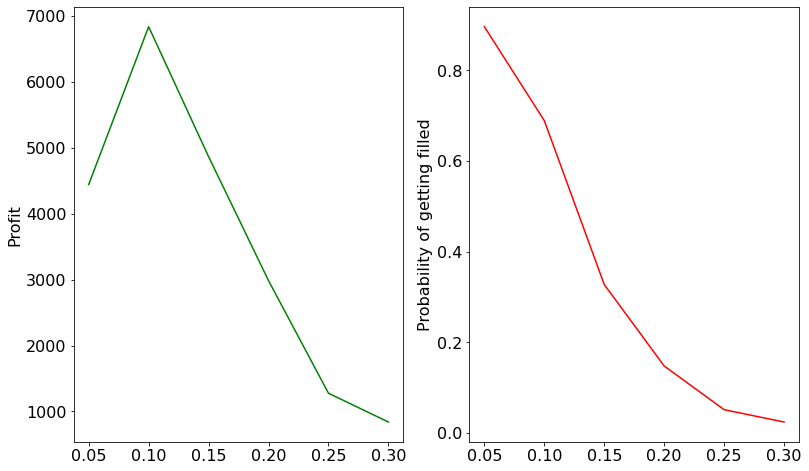

In [216]:
# Obtaining the performance of this naive model with different parameters

pl, probs = [], []
for i in np.arange(0.05, 0.35, 0.05):
    bid_spread = i
    ask_spread = i
    bids = list(data_['midPrice']-bid_spread)
    asks = list(data_['midPrice']+ask_spread)
    clear = [False]*len(bids)
    pnls, true_pnl, hit_prob, inventory_record = PnL_for_MM(data_, bids, asks, clear)
    pl.append(pnls[-1])
    probs.append(hit_prob)

fig, axs = plt.subplots(1, 2, figsize=(13,8))
spread = np.arange(0.05, 0.35, 0.05)
axs[0].plot(spread, pl, color='green')
axs[0].set_ylabel('Profit')
axs[1].plot(spread, probs, color='red')
axs[1].set_ylabel('Probability of getting filled')

# Q-Learning

Creating the Maker Class that holds all the variable and functions we will use while training the agents

In [217]:
class MakerGame:
    def __init__(self, data, inventory_quote=False):
        self.data = data
        self.time = 0
        self.inventory = 0
        self.inventory_quote = inventory_quote
        self.inventory_price = 0
    
    def step(self, action):
        reward = 0
        pnl = 0
        if self.inventory_quote:
            pass
        else:
            if action == 9:
                if np.sign(self.inventory) > 0:
                    reward += self.inventory * (self.data['bidPrice'].iloc[self.time] - self.inventory_price)
                    pnl = self.inventory * (self.data['bidPrice'].iloc[self.time] - self.inventory_price)
                else:
                    reward += self.inventory * (self.data['offerPrice'].iloc[self.time] - self.inventory_price)
                    pnl = self.inventory * (self.data['offerPrice'].iloc[self.time] - self.inventory_price)
                self.inventory_price = 0
                self.inventory = 0
            else:
                diffs = action_space[action]
                bid, ask = self.data['midPrice'].iloc[self.time] - diffs[0], self.data['midPrice'].iloc[self.time] + diffs[1]
                if self.data['trade'].iloc[self.time] > 0 :
                    hit = (ask < self.data['offerPrice'].iloc[self.time])
                else:
                    hit = (bid > self.data['bidPrice'].iloc[self.time])
                if hit:
                    new_inventory = np.clip(self.inventory - self.data['trade'].iloc[i], -100, 100)
                    amount_traded = new_inventory - self.inventory
                    if self.inventory > 0:
                        if amount_traded > 0:
                            self.inventory_price = (self.inventory_price * self.inventory + amount_traded * bid) / new_inventory
                            self.inventory = new_inventory
                            third_term = self.inventory * (self.data['midPrice'].iloc[self.time+1] - self.data['midPrice'].iloc[self.time])
                            reward = amount_traded * diffs[0] + (1-eta)* third_term
                        else:
                            if self.inventory > abs(amount_traded):
                                self.inventory = new_inventory
                                pnl = abs(amount_traded) * (ask - self.inventory_price)
                                third_term = self.inventory * (self.data['midPrice'].iloc[self.time+1] - self.data['midPrice'].iloc[self.time])
                                reward = abs(amount_traded) * diffs[1] + (1-eta)* third_term
                            else:
                                pnl = self.inventory * (ask - self.inventory_price)
                                self.inventory_price = ask
                                self.inventory = new_inventory
                                third_term = self.inventory * (self.data['midPrice'].iloc[self.time+1] - self.data['midPrice'].iloc[self.time])
                                reward = abs(amount_traded) * diffs[1] + (1-eta)* third_term
                    else:
                        if amount_traded < 0:
                            self.inventory_price = (self.inventory_price * self.inventory + amount_traded * ask) / new_inventory
                            self.inventory = new_inventory
                            third_term = self.inventory * (self.data['midPrice'].iloc[self.time+1] - self.data['midPrice'].iloc[self.time])
                            reward = abs(amount_traded) * diffs[1] + (1-eta) * third_term
                        else:
                            if abs(self.inventory) > amount_traded:
                                pnl = amount_traded * (self.inventory_price - bid)
                                self.inventory = new_inventory
                                third_term = self.inventory * (self.data['midPrice'].iloc[self.time+1] - self.data['midPrice'].iloc[self.time])
                                reward = amount_traded * diffs[0] + (1-eta) * third_term
                            else:
                                pnl = abs(self.inventory) * (self.inventory_price - bid)
                                self.inventory_price = bid
                                self.inventory = new_inventory
                                third_term = self.inventory * (self.data['midPrice'].iloc[self.time+1] - self.data['midPrice'].iloc[self.time])
                                reward = amount_traded * diffs[0] + (1-eta) * third_term
            self.time += 1
            done = True if self.time == len(self.data) - 1 else False
        return (self.inventory, reward, pnl, done)

# constant: theta, lambda, sigma
# variable: eta

In [218]:
# training the model and storing the performance results

reward_list = []
action_list1 = []
pnl_list = []

for eta in np.arange(0, 1.01, 0.05):
    epsilon = 0.9
    alpha, gamma = 0.1, 0.9


    Q_table = np.zeros((len(ParamSpace['state_space']), len(ParamSpace['A_space'])))

    r = []
    action_list = []
    t1 = perf_counter()
    for ep in range(180):
        actions = []
        env = MakerGame(data_)
        state = env.inventory
        rewards_for_one_ep = []
        pnls_for_one_ep = []
        for i in range(len(data_)-1):
            state = 10*int(state / 10)
            act = choose_action(state)
            actions.append(act)
            next_state, reward, pnl, done = env.step(act)
            next_state = 10*int(next_state / 10)
            rewards_for_one_ep.append(reward)
            pnls_for_one_ep.append(pnl)
            q_sa = Q_table[np.where(ParamSpace['state_space'] == state)[0], act]
            maxQ = np.max(Q_table[np.where(ParamSpace['state_space'] == next_state)[0], :])
            increment = alpha * (reward + gamma * maxQ - q_sa)
            Q_table[np.where(ParamSpace['state_space'] == state)[0], act] = q_sa + increment
            state = next_state

        epsilon *= 0.95
        r.append(sum(rewards_for_one_ep))
        action_list.append(actions)

    t2 = perf_counter()
    print("FINISHED. TIME ELAPSED: {} seconds".format(t2-t1))
    reward_list.append(r)
    action_list1.append(action_list[-1])
    action = action_list[-1]
    bid_spread, ask_spread, clear = [], [], []
    for i in range(len(action)):
        if action[i] == 9:
            bid_spread.append(0)
            ask_spread.append(0)
            clear.append(True)
        else:
            bid_spread.append(action_space[action[i]][0])
            ask_spread.append(action_space[action[i]][1])
            clear.append(False)

    data_ = data_.iloc[:len(bid_spread),:]
    bids = list(data_['midPrice'] - np.array(bid_spread))
    asks = list(data_['midPrice'] + np.array(ask_spread))
    pnl_list.append([eta,PnL_for_MM(data_, bids, asks, clear)])

FINISHED. TIME ELAPSED: 124.23942254000576 seconds
FINISHED. TIME ELAPSED: 101.19871811800112 seconds
FINISHED. TIME ELAPSED: 98.8003317190014 seconds
FINISHED. TIME ELAPSED: 102.81961904900527 seconds
FINISHED. TIME ELAPSED: 96.76224327100499 seconds
FINISHED. TIME ELAPSED: 96.65923169300368 seconds
FINISHED. TIME ELAPSED: 96.3039322629993 seconds
FINISHED. TIME ELAPSED: 97.33052757100086 seconds
FINISHED. TIME ELAPSED: 97.05757559499762 seconds
FINISHED. TIME ELAPSED: 97.66062302900536 seconds
FINISHED. TIME ELAPSED: 96.30790973599505 seconds
FINISHED. TIME ELAPSED: 96.4012316340013 seconds
FINISHED. TIME ELAPSED: 97.27204483300011 seconds
FINISHED. TIME ELAPSED: 96.64351985500252 seconds
FINISHED. TIME ELAPSED: 96.64501041100448 seconds
FINISHED. TIME ELAPSED: 96.52508420099912 seconds
FINISHED. TIME ELAPSED: 97.07325437100371 seconds
FINISHED. TIME ELAPSED: 100.41335332900053 seconds
FINISHED. TIME ELAPSED: 95.75669545099663 seconds
FINISHED. TIME ELAPSED: 95.61442971199722 seconds

Text(0.5, 0, 'eta value')

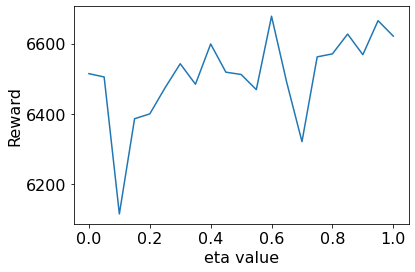

In [219]:
# plotting the final reward for different eta values

temp = []
for i in range(len(reward_list)-1, -1, -1):
    temp.append(reward_list[i][-1])
plt.plot(np.arange(0, 1.01, 0.05), temp)
plt.ylabel("Reward")
plt.xlabel('eta value')

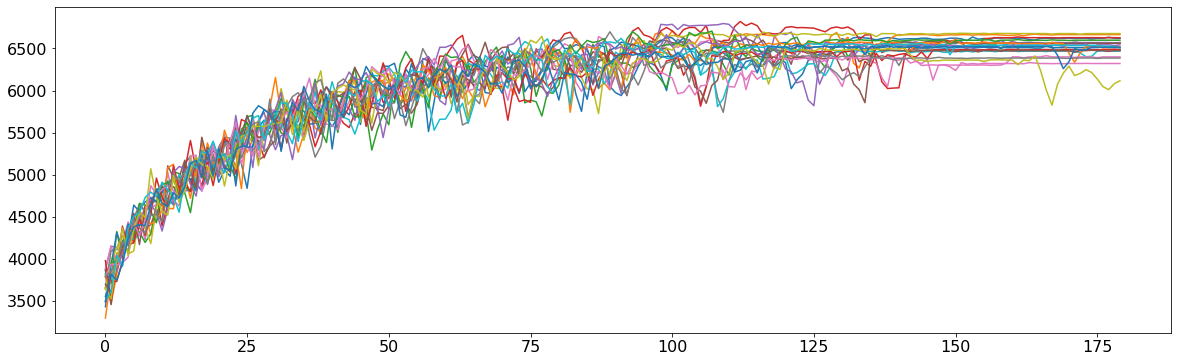

In [220]:
# looking at all the reward plots
plt.figure(figsize = (20,6))
for i in range(len(reward_list)):
    plt.plot(reward_list[i])
plt.show()

Text(0.5, 0, 'eta value')

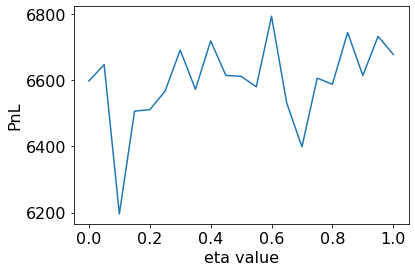

In [221]:
# plotting the final PnL for different eta values
temp = []
for i in range(len(pnl_list)-1, -1, -1):
    temp.append(pnl_list[i][1][0][-1])
plt.plot(np.arange(0, 1.01, 0.05), temp)
plt.ylabel("PnL")
plt.xlabel('eta value')

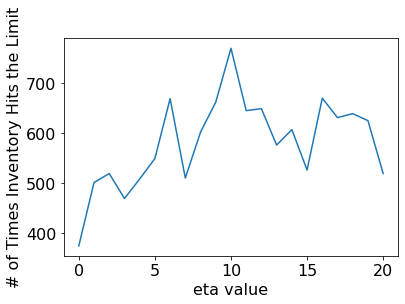

In [246]:
# plotting inventory control for different eta values

plt.plot([pnl_list[i][1][3].count(100)+pnl_list[i][1][3].count(-100) for i in range(len(pnl_list))])
plt.xlabel('eta value')
plt.ylabel('# of Times Inventory Hits the Limit');

So we see that there is stability wrt eta.

# constant: eta, sigma, theta, lambda=2.0(higher side)

In [171]:
# defining the action space
action_space = [[0.05, 0.05], [0.1, 0.1], [0.15, 0.15], [0.2, 0.2], [0.25, 0.25], [0.05, 0.15], [0.15, 0.05], [0.1, 0.2], [0.2, 0.1]]

# defining the parameter space
ParamSpace = {
    'A_space': np.arange(10),
    'state_space': np.arange(-100, 101, 10)
}

# creating a function that chooses the actions
def choose_action(state):
    rand = np.random.rand()
    if (rand < epsilon):
        action = np.random.choice(ParamSpace['A_space'], 1)[0]
    else:
        actions = Q_table[np.where(ParamSpace['state_space'] == state)[0], :]
        action = np.argmax(actions)
    return action


# defining the parameters
epsilon = 0.9
alpha, gamma = 0.1, 0.9
eta = 0.3

# defining an empty Q-Table
Q_table = np.zeros((len(ParamSpace['state_space']), len(ParamSpace['A_space'])))

# training the model and storing the performance results

r = []
action_list = []
t1 = perf_counter()
for ep in range(200):
    actions = []
    env = MakerGame(data_)
    state = env.inventory
    rewards_for_one_ep = []
    pnls_for_one_ep = []
    for i in range(len(data_)-1):
        state = 10*int(state / 10)
        act = choose_action(state)
        actions.append(act)
        next_state, reward, pnl, done = env.step(act)
        next_state = 10*int(next_state / 10)
        rewards_for_one_ep.append(reward)
        pnls_for_one_ep.append(pnl)
        q_sa = Q_table[np.where(ParamSpace['state_space'] == state)[0], act]
        maxQ = np.max(Q_table[np.where(ParamSpace['state_space'] == next_state)[0], :])
        increment = alpha * (reward + gamma * maxQ - q_sa)
        Q_table[np.where(ParamSpace['state_space'] == state)[0], act] = q_sa + increment
        
        state = next_state

    epsilon *= 0.95
    r.append(sum(rewards_for_one_ep))
    action_list.append(actions)
    print('done', ep)
t2 = perf_counter()
print("FINISHED. TIME ELAPSED: {} seconds".format(t2-t1))

done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 12
done 13
done 14
done 15
done 16
done 17
done 18
done 19
done 20
done 21
done 22
done 23
done 24
done 25
done 26
done 27
done 28
done 29
done 30
done 31
done 32
done 33
done 34
done 35
done 36
done 37
done 38
done 39
done 40
done 41
done 42
done 43
done 44
done 45
done 46
done 47
done 48
done 49
done 50
done 51
done 52
done 53
done 54
done 55
done 56
done 57
done 58
done 59
done 60
done 61
done 62
done 63
done 64
done 65
done 66
done 67
done 68
done 69
done 70
done 71
done 72
done 73
done 74
done 75
done 76
done 77
done 78
done 79
done 80
done 81
done 82
done 83
done 84
done 85
done 86
done 87
done 88
done 89
done 90
done 91
done 92
done 93
done 94
done 95
done 96
done 97
done 98
done 99
done 100
done 101
done 102
done 103
done 104
done 105
done 106
done 107
done 108
done 109
done 110
done 111
done 112
done 113
done 114
done 115
done 116
done 117
done 118
done 119
done 120
done 121
done 122
don

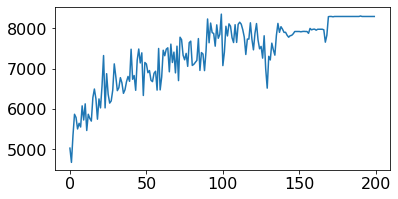

In [172]:
# reward plot over episodes

plt.figure(figsize = (6,3))
plt.plot(r)

----------------------------
P&L in total is 7808.349999999823
Standard deviation of P&L is 6.435299374758565
7808.349999999821
----------------------------


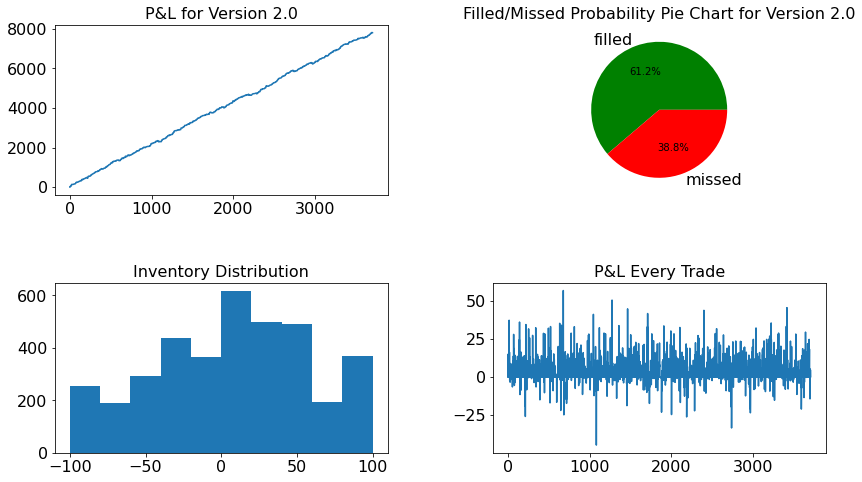

In [176]:
# interpreting the final action list creating by the agent for the data
action = action_list[-1]
bid_spread, ask_spread, clear = [], [], []
for i in range(len(action)):
    if action[i] == 9:
        bid_spread.append(0)
        ask_spread.append(0)
        clear.append(True)
    else:
        bid_spread.append(action_space[action[i]][0])
        ask_spread.append(action_space[action[i]][1])
        clear.append(False)

# Finding performance of the agent on the data
data_ = data_.iloc[:len(bid_spread),:]
bids = list(data_['midPrice'] - np.array(bid_spread))
asks = list(data_['midPrice'] + np.array(ask_spread))
pnls, true_pnl, hit_prob, inventory_record = PnL_for_MM(data_, bids, asks, clear)

fig, axs = plt.subplots(2, 2,figsize=(13,8))
fig.tight_layout(pad=6.0)

axs[0][0].plot(pnls)
axs[0][0].set_title("P&L for Version 2.0")
axs[0][1].pie([hit_prob*100, 100-hit_prob*100], labels=['filled', 'missed'],autopct='%1.1f%%', colors=['green', 'red'])
axs[0][1].set_title('Filled/Missed Probability Pie Chart for Version 2.0')
axs[1][0].hist(inventory_record)
axs[1][0].set_title("Inventory Distribution")
axs[1][1].plot(np.diff(pnls)[:-1])
axs[1][1].set_title('P&L Every Trade')

print("----------------------------")
print("P&L in total is {}".format(pnls[-1]))
print("Standard deviation of P&L is {}".format(np.std(np.diff(pnls[:-1]))))
print(true_pnl)
print("----------------------------")

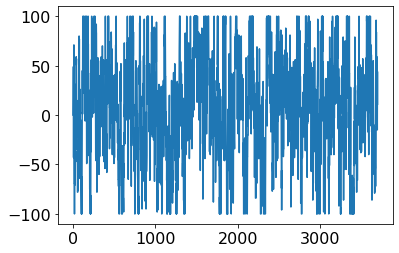

In [177]:
# looking at the inventory over time
plt.plot(inventory_record)

[[1, 487], [2, 777], [5, 519], [6, 176], [7, 734], [8, 1009]]


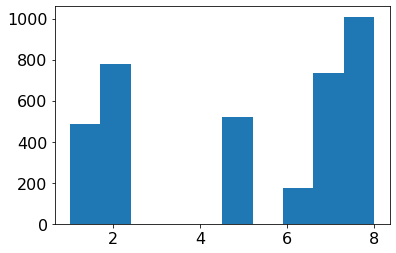

In [178]:
# Finding the actions taken by the agent for the dataset
d = {}
for i in range(len(action)):
    d[action[i]] = d.get(action[i],0)+1
m = []
for k,v in d.items():
    m.append([k,v])
m.sort()
print(m)
plt.hist(action_list[-1]);

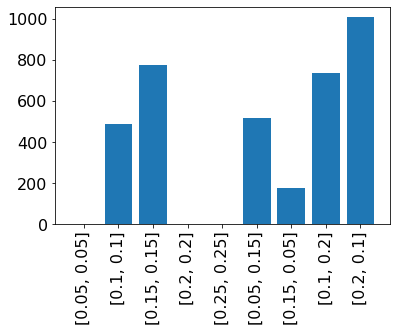

In [191]:
# Clearer chart for actions taken
m.append([0,0])
m.append([3,0])
m.append([4,0])
m.sort()
am = [m[i][1] for i in range(len(m))]
aspc = [str(action_space[i]) for i in range(len(action_space))]
plt.bar(aspc,am)
plt.xticks(rotation=90);

# constant: lambda, eta;
# variable: theta, sigma

In [257]:
# obtaining the datasets for the varying parameters

def get_covariance(sigma: float, delta: float, theta: np.ndarray) -> np.ndarray:
    theta_p = theta + theta.T
    return (sigma ** 2.0) * inv(theta_p) * (np.eye(theta.shape[0]) - expm(-theta_p * delta))


def sample_gaussian(n: int, covariance: np.ndarray) -> np.ndarray:
    d, v = eig(covariance)
    a = np.dot(v, np.diag(np.sqrt(np.real(d))))
    g = np.random.normal(0.0, 1.0, (a.shape[0], n))
    return np.dot(a, g)


def sample_mean_reversion(n: int, x0: np.ndarray, mu: np.ndarray, sigma: float, delta: float,
                          theta: np.ndarray) -> np.ndarray:
    if not positive_eigenvalues(theta):
        raise AssertionError("Input theta does not have all positive eigenvalues")
    covariance = get_covariance(sigma, delta, theta)
    if not positive_eigenvalues(covariance):
        raise AssertionError("Covariance does not have all positive eigenvalues")
    gaussian_matrix = sample_gaussian(n, covariance)
    sample_paths = np.ndarray(gaussian_matrix.shape)
    sample_paths[:, [0]] = x0
    exp_theta = expm(-theta * delta)
    for i in range(1, sample_paths.shape[1]):
        prev = sample_paths[:, [i - 1]]
        sample_paths[:, [i]] = mu + np.dot(exp_theta, (prev - mu)) + gaussian_matrix[:, [i - 1]]
    return sample_paths


def positive_eigenvalues(theta: np.ndarray) -> bool:
    d, v = eig(theta)
    return np.all(np.real(d) > 0.0)


specs = pd.DataFrame(data={'p0': [100.0, 110.0, 150.0], # starting point                      
                           'mu': [100.0, 110.0, 80.0],  # mean                       
                           'theta': [0.05, 0.02, 0.0003],   # AR1 modal theta for yt = delta + (theta*yt-1) + Et
                           'sigma': [0.05, 0.02, 0.1],    # standard deviation
                           'lam': [0.05, 2.0, 0.05],    # bid-ask spread
                           'date': ['20200901', '20200909', '20200916']},
                     index=[1, 2, 3])

def generate_data(th,sig):
    episode = 2
    train = False
    episode_specs = specs.loc[episode]
    date = episode_specs.date
    file_name = 'sample_data_' + date + '_' + str(episode) + ('_train.csv' if train else '_mytest.csv')
    seed = 0
    p0 = episode_specs['p0']  # 100.0, 110.0
    mu = episode_specs['mu']  # 100.0, 110.0
    theta = th
    sigma = sig
    n = 36_000
    display = 30_000
    lam = episode_specs['lam']  # 0.05, 2.0
    resolution = 1.0 / 10.0  # per dollar
    q_min = 50.0
    q_max = 100.0

    np.random.seed(seed)
    default_font_size = 16
    model_type = 'tree'  # it can be 'tree' or 'nn'

    gaussian_vector = np.random.normal(0.0, 1.0, 2 * n)
    poisson_vector = 1 + np.random.poisson(lam, 2 * n)
    quantities = np.round(np.random.uniform(size=(2 * n, 2)) * (q_max - q_min) + q_min)
    mid = np.ndarray(2 * n)
    p = p0
    for i in range(2 * n):
        pm1 = p0 if i == 0 else mid[i - 1]
        mid[i] = pm1 + np.floor((theta * (mu - pm1) + sigma * gaussian_vector[i]) / resolution + 0.5) * resolution
    spread = resolution * poisson_vector
    order_books = pd.DataFrame(data={'bidPrice': mid - 0.5 * spread, 'offerPrice': mid + 0.5 * spread,
                                     'bidQty': quantities[:, 0], 'offerQty': quantities[:, 1]})
    order_books.index.name = 'time'
    order_books = order_books.iloc[:n] if train else order_books.iloc[n:]

    formats = {'bidPrice': '{:.2f}', 'offerPrice': '{:.2f}', 'bidQty': '{:.0f}', 'offerQty': '{:.0f}'}
    for col, f in formats.items():
        order_books[col] = order_books[col].map(lambda x: f.format(x))
    order_books.to_csv(file_name, float_format='%.3f')

In [258]:
# Training the agent in different scenarios and storing the results

reward_list = []
pnl_list = []
action_list = []
eta = 0.5

for T in [0.005, 0.02, 0.04, 0.06]:
    for S in [0.005, 0.02, 0.04, 0.06, 0.08]:
        
        epsilon = 0.9
        alpha, gamma = 0.1, 0.9
        
        generate_data(T,S)
        
        MM_train = pd.read_csv('noise_trades__train.csv', index_col = 0)
        week1 = pd.read_csv('sample_data_20200909_2_mytest.csv', index_col = 0)
        MM_train['trade'] = 0
        MM_train['trade'] = -1*(MM_train['side'] == 'SELL') + 1*(MM_train['side'] == 'BUY')
        MM_train['qty'].fillna(0,inplace= True)
        trd = MM_train['trade']
        qyt = MM_train['qty']
        trdqyt = [trd[i]*qyt[i] for i in range(len(trd))]
        week1['trade'] = trdqyt
        week1['midPrice'] = (week1['bidPrice'] + week1['offerPrice'])/2
        data_ = week1.loc[week1['trade']!=0, :].copy()
        
        Q_table = np.zeros((len(ParamSpace['state_space']), len(ParamSpace['A_space'])))

        r = []
        action_list = []
        t1 = perf_counter()
        for ep in range(175):
            actions = []
            env = MakerGame(data_)
            state = env.inventory
            rewards_for_one_ep = []
            pnls_for_one_ep = []
            for i in range(len(data_)-1):
                state = 10*int(state / 10)
                act = choose_action(state)
                actions.append(act)
                next_state, reward, pnl, done = env.step(act)
                next_state = 10*int(next_state / 10)
                rewards_for_one_ep.append(reward)
                pnls_for_one_ep.append(pnl)
                q_sa = Q_table[np.where(ParamSpace['state_space'] == state)[0], act]
                maxQ = np.max(Q_table[np.where(ParamSpace['state_space'] == next_state)[0], :])
                increment = alpha * (reward + gamma * maxQ - q_sa)
                Q_table[np.where(ParamSpace['state_space'] == state)[0], act] = q_sa + increment
                state = next_state

            epsilon *= 0.95
            r.append(sum(rewards_for_one_ep))
            action_list.append(actions)
        
        t2 = perf_counter()
        print("FINISHED. TIME ELAPSED: {} seconds".format(t2-t1))
        reward_list.append(r)
        
        action = action_list[-1]
        bid_spread, ask_spread, clear = [], [], []
        for i in range(len(action)):
            if action[i] == 9:
                bid_spread.append(0)
                ask_spread.append(0)
                clear.append(True)
            else:
                bid_spread.append(action_space[action[i]][0])
                ask_spread.append(action_space[action[i]][1])
                clear.append(False)
        
        data_ = data_.iloc[:len(bid_spread),:]
        bids = list(data_['midPrice'] - np.array(bid_spread))
        asks = list(data_['midPrice'] + np.array(ask_spread))
        pnl_list.append([T,S,PnL_for_MM(data_, bids, asks, clear)])
        action_list.append(action)
        print(pnl_list[-1][0],pnl_list[-1][1],pnl_list[-1][2][0][-1])

FINISHED. TIME ELAPSED: 133.2016286279977 seconds
0.005 0.005 5618.699999999635
FINISHED. TIME ELAPSED: 115.04868797901145 seconds
0.005 0.02 7041.149999999588
FINISHED. TIME ELAPSED: 108.5165504829929 seconds
0.005 0.04 7196.2499999995825
FINISHED. TIME ELAPSED: 112.63914288199157 seconds
0.005 0.06 6576.849999999618
FINISHED. TIME ELAPSED: 113.44789620098891 seconds
0.005 0.08 6192.299999999746
FINISHED. TIME ELAPSED: 111.90638356001 seconds
0.02 0.005 5618.699999999635
FINISHED. TIME ELAPSED: 115.69434517600166 seconds
0.02 0.02 6902.249999999623
FINISHED. TIME ELAPSED: 106.96150144501007 seconds
0.02 0.04 6516.849999999577
FINISHED. TIME ELAPSED: 105.00086680799723 seconds
0.02 0.06 6810.4499999995405
FINISHED. TIME ELAPSED: 108.74973983000382 seconds
0.02 0.08 6171.349999999671
FINISHED. TIME ELAPSED: 119.23618227300176 seconds
0.04 0.005 5618.699999999635
FINISHED. TIME ELAPSED: 116.69490264600608 seconds
0.04 0.02 6978.999999999598
FINISHED. TIME ELAPSED: 122.04491569800302 seco

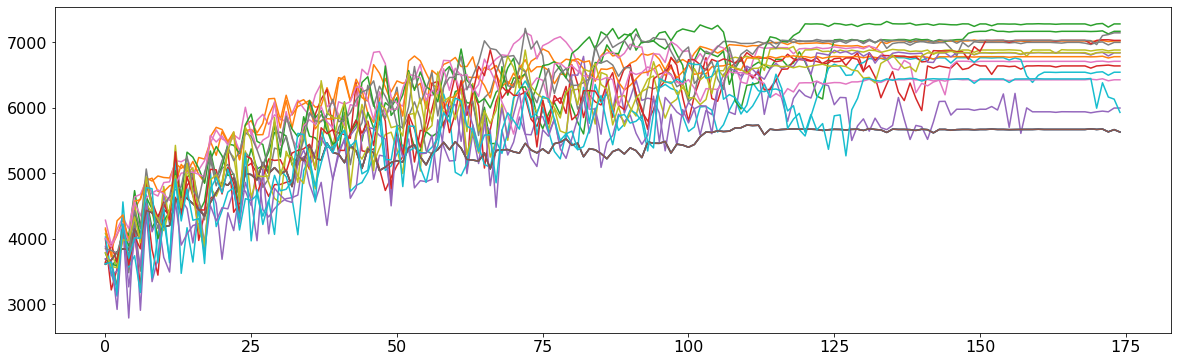

In [259]:
# reward plots

plt.figure(figsize = (20,6))
for i in range(len(reward_list)):
    plt.plot(reward_list[i])
plt.show()

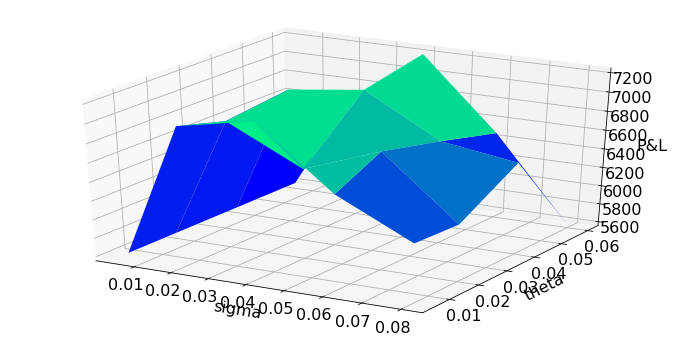

In [271]:
# generating a 3D plot of the performance

fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection="3d")

x = np.array([0.005,0.02,0.04,0.06, 0.08])
y = np.array([0.005,0.02,0.04,0.06])

X, Y = np.meshgrid(x, y)
Z = [[],[],[],[]]
Z[0] = [pnl_list[i][2][0][-1] for i in range(5)]
Z[1] = [pnl_list[i][2][0][-1] for i in range(5,10)]
Z[2] = [pnl_list[i][2][0][-1] for i in range(10,15)]
Z[3] = [pnl_list[i][2][0][-1] for i in range(15,20)]
Z = np.array(Z)


ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.set_xlabel('sigma')
ax.set_ylabel('theta')
ax.set_zlabel('P&L')

plt.show();

In [261]:
final_rewards = []
for i in [0.005, 0.02, 0.04, 0.06]:
    for j in [0.005, 0.02, 0.04, 0.06, 0.08]:
        final_rewards.append([i,j])
for i in range(20):
    final_rewards[i].append(reward_list[i][-1])
def third(x):
    return x[2]
final_rewards.sort(key=third,reverse=True)
final_rewards

[[0.04, 0.04, 7280.449999999998],
 [0.005, 0.04, 7167.499999999948],
 [0.06, 0.04, 7144.499999999981],
 [0.04, 0.06, 7029.1999999999725],
 [0.005, 0.02, 7020.449999999976],
 [0.02, 0.04, 6998.6999999999825],
 [0.02, 0.06, 6882.199999999976],
 [0.06, 0.06, 6842.399999999994],
 [0.04, 0.08, 6838.499999999977],
 [0.04, 0.02, 6780.499999999997],
 [0.02, 0.02, 6709.749999999991],
 [0.005, 0.06, 6639.349999999998],
 [0.02, 0.08, 6543.299999999991],
 [0.06, 0.02, 6427.849999999977],
 [0.005, 0.08, 5996.700000000015],
 [0.06, 0.08, 5930.049999999973],
 [0.005, 0.005, 5630.249999999985],
 [0.02, 0.005, 5630.249999999985],
 [0.04, 0.005, 5630.249999999985],
 [0.06, 0.005, 5630.249999999985]]

In [263]:
final_PnLs = []
for i in [0.005, 0.02, 0.04, 0.06]:
    for j in [0.005, 0.02, 0.04, 0.06, 0.08]:
        final_PnLs.append([i,j])
for i in range(20):
    final_PnLs[i].append(pnl_list[i][2][0][-1])
def third(x):
    return x[2]
final_PnLs.sort(key=third,reverse=True)
final_PnLs

[[0.06, 0.04, 7212.949999999587],
 [0.005, 0.04, 7196.2499999995825],
 [0.04, 0.04, 7079.849999999569],
 [0.005, 0.02, 7041.149999999588],
 [0.04, 0.02, 6978.999999999598],
 [0.02, 0.02, 6902.249999999623],
 [0.02, 0.06, 6810.4499999995405],
 [0.04, 0.06, 6654.349999999609],
 [0.06, 0.02, 6601.299999999659],
 [0.005, 0.06, 6576.849999999618],
 [0.04, 0.08, 6539.9999999996435],
 [0.02, 0.04, 6516.849999999577],
 [0.06, 0.06, 6482.499999999659],
 [0.005, 0.08, 6192.299999999746],
 [0.02, 0.08, 6171.349999999671],
 [0.005, 0.005, 5618.699999999635],
 [0.02, 0.005, 5618.699999999635],
 [0.04, 0.005, 5618.699999999635],
 [0.06, 0.005, 5618.699999999635],
 [0.06, 0.08, 5590.949999999698]]

# Varying Sigma, Constant everything else

In [378]:
def get_covariance(sigma: float, delta: float, theta: np.ndarray) -> np.ndarray:
    theta_p = theta + theta.T
    return (sigma ** 2.0) * inv(theta_p) * (np.eye(theta.shape[0]) - expm(-theta_p * delta))


def sample_gaussian(n: int, covariance: np.ndarray) -> np.ndarray:
    d, v = eig(covariance)
    a = np.dot(v, np.diag(np.sqrt(np.real(d))))
    g = np.random.normal(0.0, 1.0, (a.shape[0], n))
    return np.dot(a, g)


def sample_mean_reversion(n: int, x0: np.ndarray, mu: np.ndarray, sigma: float, delta: float,
                          theta: np.ndarray) -> np.ndarray:
    if not positive_eigenvalues(theta):
        raise AssertionError("Input theta does not have all positive eigenvalues")
    covariance = get_covariance(sigma, delta, theta)
    if not positive_eigenvalues(covariance):
        raise AssertionError("Covariance does not have all positive eigenvalues")
    gaussian_matrix = sample_gaussian(n, covariance)
    sample_paths = np.ndarray(gaussian_matrix.shape)
    sample_paths[:, [0]] = x0
    exp_theta = expm(-theta * delta)
    for i in range(1, sample_paths.shape[1]):
        prev = sample_paths[:, [i - 1]]
        sample_paths[:, [i]] = mu + np.dot(exp_theta, (prev - mu)) + gaussian_matrix[:, [i - 1]]
    return sample_paths


def positive_eigenvalues(theta: np.ndarray) -> bool:
    d, v = eig(theta)
    return np.all(np.real(d) > 0.0)


specs = pd.DataFrame(data={'p0': [100.0, 110.0, 150.0], # starting point                      
                           'mu': [100.0, 110.0, 80.0],  # mean                       
                           'theta': [0.05, 0.02, 0.0003],   # AR1 modal theta for yt = delta + (theta*yt-1) + Et
                           'sigma': [0.05, 0.02, 0.1],    # standard deviation
                           'lam': [0.05, 2.0, 0.05],    # bid-ask spread
                           'date': ['20200901', '20200909', '20200916']},
                     index=[1, 2, 3])

def generate_data(th,sig):
    episode = 2
    train = False
    episode_specs = specs.loc[episode]
    date = episode_specs.date
    file_name = 'sample_data_' + date + '_' + str(episode) + ('_train.csv' if train else '_mytest.csv')
    seed = 0
    p0 = episode_specs['p0']  # 100.0, 110.0
    mu = episode_specs['mu']  # 100.0, 110.0
    theta = th
    sigma = sig
    n = 36_000
    display = 30_000
    lam = 0.5  # 0.05, 2.0
    resolution = 1.0 / 10.0  # per dollar
    q_min = 50.0
    q_max = 100.0

    np.random.seed(seed)
    default_font_size = 16
    model_type = 'tree'  # it can be 'tree' or 'nn'

    gaussian_vector = np.random.normal(0.0, 1.0, 2 * n)
    poisson_vector = 1 + np.random.poisson(lam, 2 * n)
    quantities = np.round(np.random.uniform(size=(2 * n, 2)) * (q_max - q_min) + q_min)
    mid = np.ndarray(2 * n)
    p = p0
    for i in range(2 * n):
        pm1 = p0 if i == 0 else mid[i - 1]
        mid[i] = pm1 + np.floor((theta * (mu - pm1) + sigma * gaussian_vector[i]) / resolution + 0.5) * resolution
    spread = resolution * poisson_vector
    order_books = pd.DataFrame(data={'bidPrice': mid - 0.5 * spread, 'offerPrice': mid + 0.5 * spread,
                                     'bidQty': quantities[:, 0], 'offerQty': quantities[:, 1]})
    order_books.index.name = 'time'
    order_books = order_books.iloc[:n] if train else order_books.iloc[n:]

    formats = {'bidPrice': '{:.2f}', 'offerPrice': '{:.2f}', 'bidQty': '{:.0f}', 'offerQty': '{:.0f}'}
    for col, f in formats.items():
        order_books[col] = order_books[col].map(lambda x: f.format(x))
    order_books.to_csv(file_name, float_format='%.3f')

In [379]:
reward_list = []
pnl_list = []
actions_List = []
eta = 0.5

for T in [0.035]:
    for S in [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]:
        
        epsilon = 0.9
        alpha, gamma = 0.1, 0.9
        
        generate_data(T,S)
        
        MM_train = pd.read_csv('noise_trades__train.csv', index_col = 0)
        week1 = pd.read_csv('sample_data_20200909_2_mytest.csv', index_col = 0)
        MM_train['trade'] = 0
        MM_train['trade'] = -1*(MM_train['side'] == 'SELL') + 1*(MM_train['side'] == 'BUY')
        MM_train['qty'].fillna(0,inplace= True)
        trd = MM_train['trade']
        qyt = MM_train['qty']
        trdqyt = [trd[i]*qyt[i] for i in range(len(trd))]
        week1['trade'] = trdqyt
        week1['midPrice'] = (week1['bidPrice'] + week1['offerPrice'])/2
        data_ = week1.loc[week1['trade']!=0, :].copy()
        
        Q_table = np.zeros((len(ParamSpace['state_space']), len(ParamSpace['A_space'])))

        r = []
        action_list = []
        t1 = perf_counter()
        for ep in range(175):
            actions = []
            env = MakerGame(data_)
            state = env.inventory
            rewards_for_one_ep = []
            pnls_for_one_ep = []
            for i in range(len(data_)-1):
                state = 10*int(state / 10)
                act = choose_action(state)
                actions.append(act)
                next_state, reward, pnl, done = env.step(act)
                next_state = 10*int(next_state / 10)
                rewards_for_one_ep.append(reward)
                pnls_for_one_ep.append(pnl)
                q_sa = Q_table[np.where(ParamSpace['state_space'] == state)[0], act]
                maxQ = np.max(Q_table[np.where(ParamSpace['state_space'] == next_state)[0], :])
                increment = alpha * (reward + gamma * maxQ - q_sa)
                Q_table[np.where(ParamSpace['state_space'] == state)[0], act] = q_sa + increment
                state = next_state

            epsilon *= 0.95
            r.append(sum(rewards_for_one_ep))
            action_list.append(actions)
        
        t2 = perf_counter()
        print("FINISHED. TIME ELAPSED: {} seconds".format(t2-t1))
        reward_list.append(r)
        
        action = action_list[-1]
        bid_spread, ask_spread, clear = [], [], []
        for i in range(len(action)):
            if action[i] == 9:
                bid_spread.append(0)
                ask_spread.append(0)
                clear.append(True)
            else:
                bid_spread.append(action_space[action[i]][0])
                ask_spread.append(action_space[action[i]][1])
                clear.append(False)
        
        data_ = data_.iloc[:len(bid_spread),:]
        bids = list(data_['midPrice'] - np.array(bid_spread))
        asks = list(data_['midPrice'] + np.array(ask_spread))
        pnl_list.append([T,S,PnL_for_MM(data_, bids, asks, clear)])
        actions_List.append(action)
        print(pnl_list[-1][0],pnl_list[-1][1],pnl_list[-1][2][0][-1])

FINISHED. TIME ELAPSED: 86.31998122899677 seconds
0.035 0.001 1958.4999999998415
FINISHED. TIME ELAPSED: 80.99215080701106 seconds
0.035 0.01 1958.4999999998415
FINISHED. TIME ELAPSED: 84.90491768698848 seconds
0.035 0.02 3308.0999999998335
FINISHED. TIME ELAPSED: 110.525996493001 seconds
0.035 0.03 3096.6499999998273
FINISHED. TIME ELAPSED: 102.45116943000176 seconds
0.035 0.04 2390.54999999981
FINISHED. TIME ELAPSED: 91.61038411299523 seconds
0.035 0.05 2488.7999999998183
FINISHED. TIME ELAPSED: 95.53751314399415 seconds
0.035 0.06 1817.4499999998436
FINISHED. TIME ELAPSED: 88.07672263699351 seconds
0.035 0.07 1446.199999999836
FINISHED. TIME ELAPSED: 99.01616955899226 seconds
0.035 0.08 1437.3499999998044


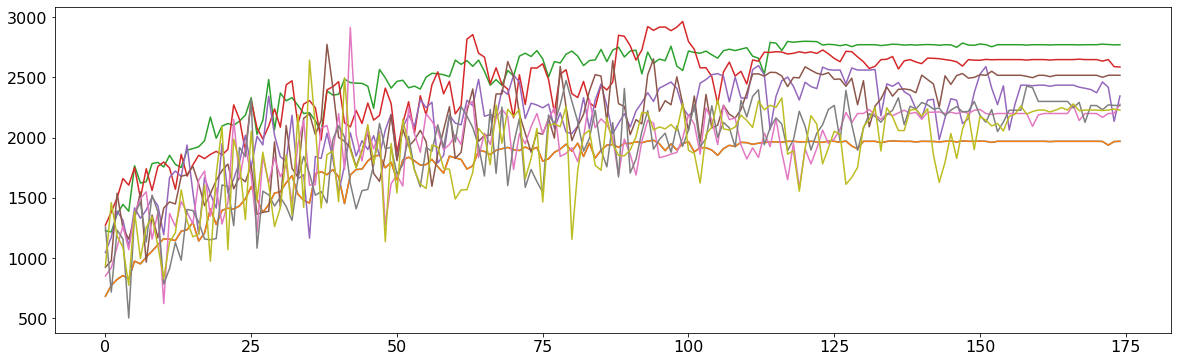

In [380]:
# reward plots

plt.figure(figsize = (20,6))
for i in range(len(reward_list)):
    plt.plot(reward_list[i])
plt.show()

In [381]:
final_PnLs = []
for i in [0.02]:
    for j in [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]:
        final_PnLs.append([i,j])
for i in range(9):
    final_PnLs[i].append(pnl_list[i][2][0][-1])
final_PnLs

[[0.02, 0.001, 1958.4999999998415],
 [0.02, 0.01, 1958.4999999998415],
 [0.02, 0.02, 3308.0999999998335],
 [0.02, 0.03, 3096.6499999998273],
 [0.02, 0.04, 2390.54999999981],
 [0.02, 0.05, 2488.7999999998183],
 [0.02, 0.06, 1817.4499999998436],
 [0.02, 0.07, 1446.199999999836],
 [0.02, 0.08, 1437.3499999998044]]

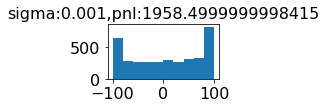

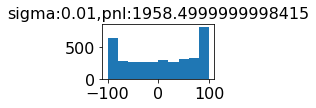

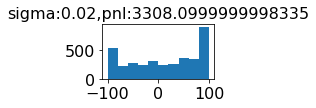

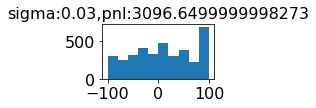

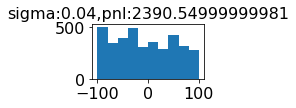

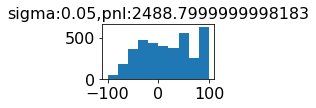

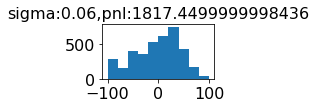

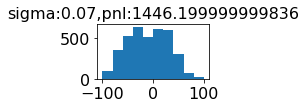

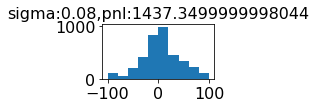

In [382]:
# looking at the inventory distributions for different market scenarios
for i in range(len(pnl_list)):
    plt.figure(figsize = (2,1))
    plt.hist(pnl_list[i][2][3])
    plt.title('sigma:'+str(pnl_list[i][1])+','+'pnl:'+str(pnl_list[i][2][0][-1]))
    plt.show()

Text(0.5, 0, 'sigma')

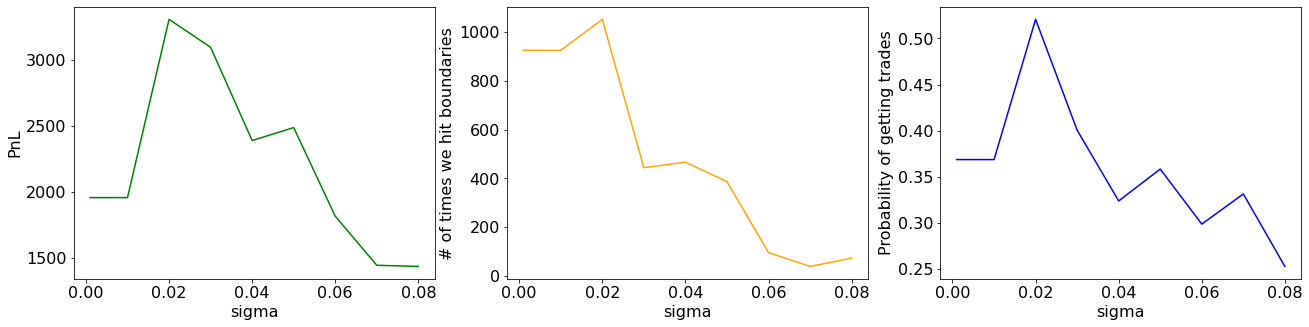

In [399]:
# exploring why PnL vs Sigma curve is the way it is

xxx = []
yyy = []
yy = []
for i in range(len(pnl_list)):
    abc = pnl_list[i][2][3]
    no_of_bndry_hits = abc.count(100)+abc.count(-100)
    xxx.append(pnl_list[i][1])
    yy.append(pnl_list[i][2][0][-1])
    yyy.append(no_of_bndry_hits)
yyyy = [pnl_list[i][2][2] for i in range(len(pnl_list))]
fig, axs = plt.subplots(1, 3, figsize=(22,5))
axs[1].plot(xxx, yyy, color='orange')
axs[1].set_ylabel('# of times we hit boundaries')
axs[1].set_xlabel('sigma')
axs[0].plot(xxx, yy, color='green')
axs[0].set_ylabel('PnL')
axs[0].set_xlabel('sigma')
axs[2].plot(xxx, yyyy, color='blue')
axs[2].set_ylabel('Probability of getting trades')
axs[2].set_xlabel('sigma')

In [385]:
# finding how many times inventory was cleared for different scenarios

for i in range(len(actions_List)):
    print('sigma:',pnl_list[i][1],'PnL:',pnl_list[i][2][0][-1],'# we cleared inventory:',actions_List[i].count(9))

sigma: 0.001 PnL: 1958.4999999998415 # we cleared inventory: 0
sigma: 0.01 PnL: 1958.4999999998415 # we cleared inventory: 0
sigma: 0.02 PnL: 3308.0999999998335 # we cleared inventory: 0
sigma: 0.03 PnL: 3096.6499999998273 # we cleared inventory: 106
sigma: 0.04 PnL: 2390.54999999981 # we cleared inventory: 1
sigma: 0.05 PnL: 2488.7999999998183 # we cleared inventory: 0
sigma: 0.06 PnL: 1817.4499999998436 # we cleared inventory: 0
sigma: 0.07 PnL: 1446.199999999836 # we cleared inventory: 113
sigma: 0.08 PnL: 1437.3499999998044 # we cleared inventory: 117


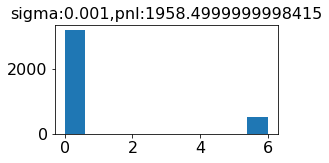

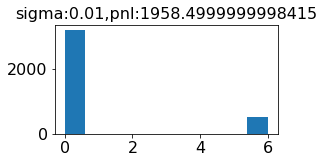

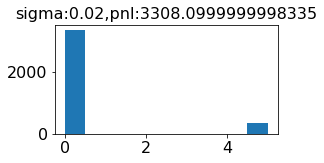

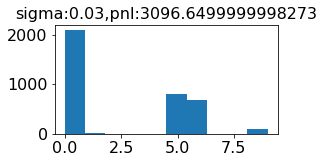

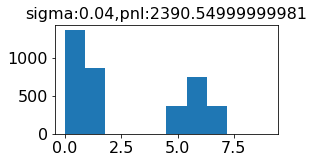

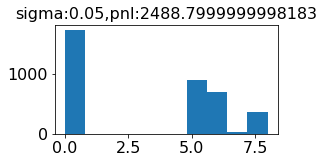

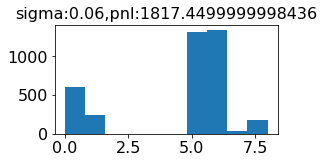

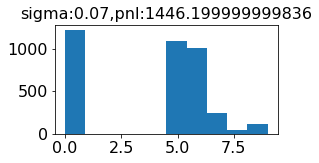

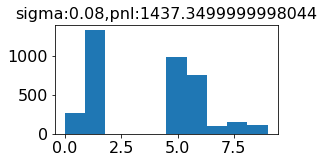

In [386]:
# looking at the best actions for different market scenarios

for i in range(len(pnl_list)):
    plt.figure(figsize = (4,2))
    plt.hist(actions_List[i])
    plt.title('sigma:'+str(pnl_list[i][1])+','+'pnl:'+str(pnl_list[i][2][0][-1]))
    plt.show()

# constant: theta, eta
# variable: sigma, lambda

In [130]:
def get_covariance(sigma: float, delta: float, theta: np.ndarray) -> np.ndarray:
    theta_p = theta + theta.T
    return (sigma ** 2.0) * inv(theta_p) * (np.eye(theta.shape[0]) - expm(-theta_p * delta))


def sample_gaussian(n: int, covariance: np.ndarray) -> np.ndarray:
    d, v = eig(covariance)
    a = np.dot(v, np.diag(np.sqrt(np.real(d))))
    g = np.random.normal(0.0, 1.0, (a.shape[0], n))
    return np.dot(a, g)


def sample_mean_reversion(n: int, x0: np.ndarray, mu: np.ndarray, sigma: float, delta: float,
                          theta: np.ndarray) -> np.ndarray:
    if not positive_eigenvalues(theta):
        raise AssertionError("Input theta does not have all positive eigenvalues")
    covariance = get_covariance(sigma, delta, theta)
    if not positive_eigenvalues(covariance):
        raise AssertionError("Covariance does not have all positive eigenvalues")
    gaussian_matrix = sample_gaussian(n, covariance)
    sample_paths = np.ndarray(gaussian_matrix.shape)
    sample_paths[:, [0]] = x0
    exp_theta = expm(-theta * delta)
    for i in range(1, sample_paths.shape[1]):
        prev = sample_paths[:, [i - 1]]
        sample_paths[:, [i]] = mu + np.dot(exp_theta, (prev - mu)) + gaussian_matrix[:, [i - 1]]
    return sample_paths


def positive_eigenvalues(theta: np.ndarray) -> bool:
    d, v = eig(theta)
    return np.all(np.real(d) > 0.0)


specs = pd.DataFrame(data={'p0': [100.0, 110.0, 150.0], # starting point                      
                           'mu': [100.0, 110.0, 80.0],  # mean                       
                           'theta': [0.05, 0.02, 0.0003],   # AR1 modal theta for yt = delta + (theta*yt-1) + Et
                           'sigma': [0.05, 0.02, 0.1],    # standard deviation
                           'lam': [0.05, 2.0, 0.05],    # bid-ask spread
                           'date': ['20200901', '20200909', '20200916']},
                     index=[1, 2, 3])

def generate_data(lmbd,sig):
    episode = 2
    train = False
    episode_specs = specs.loc[episode]
    date = episode_specs.date
    file_name = 'sample_data_' + date + '_' + str(episode) + ('_train.csv' if train else '_mytest.csv')
    seed = 0
    p0 = episode_specs['p0']  # 100.0, 110.0
    mu = episode_specs['mu']  # 100.0, 110.0
    theta = 0.02
    sigma = sig
    n = 36_000
    display = 30_000
    lam = lmbd
    resolution = 1.0 / 10.0  # per dollar
    q_min = 50.0
    q_max = 100.0

    np.random.seed(seed)
    default_font_size = 16
    model_type = 'tree'  # it can be 'tree' or 'nn'

    gaussian_vector = np.random.normal(0.0, 1.0, 2 * n)
    poisson_vector = 1 + np.random.poisson(lam, 2 * n)
    quantities = np.round(np.random.uniform(size=(2 * n, 2)) * (q_max - q_min) + q_min)
    mid = np.ndarray(2 * n)
    p = p0
    for i in range(2 * n):
        pm1 = p0 if i == 0 else mid[i - 1]
        mid[i] = pm1 + np.floor((theta * (mu - pm1) + sigma * gaussian_vector[i]) / resolution + 0.5) * resolution
    spread = resolution * poisson_vector
    order_books = pd.DataFrame(data={'bidPrice': mid - 0.5 * spread, 'offerPrice': mid + 0.5 * spread,
                                     'bidQty': quantities[:, 0], 'offerQty': quantities[:, 1]})
    order_books.index.name = 'time'
    order_books = order_books.iloc[:n] if train else order_books.iloc[n:]

    formats = {'bidPrice': '{:.2f}', 'offerPrice': '{:.2f}', 'bidQty': '{:.0f}', 'offerQty': '{:.0f}'}
    for col, f in formats.items():
        order_books[col] = order_books[col].map(lambda x: f.format(x))
    order_books.to_csv(file_name, float_format='%.3f')

In [132]:
reward_list = []
pnl_list = []
action_list = []
eta = 0.9

for L in [0.05, 1.0, 2.0, 2.75]:
    for S in [0.005, 0.02, 0.04, 0.06]:
        
        epsilon = 0.9
        alpha, gamma = 0.1, 0.9
        
        generate_data(L,S)
        
        MM_train = pd.read_csv('noise_trades__train.csv', index_col = 0)
        week1 = pd.read_csv('sample_data_20200909_2_mytest.csv', index_col = 0)
        MM_train['trade'] = 0
        MM_train['trade'] = -1*(MM_train['side'] == 'SELL') + 1*(MM_train['side'] == 'BUY')
        MM_train['qty'].fillna(0,inplace= True)
        trd = MM_train['trade']
        qyt = MM_train['qty']
        trdqyt = [trd[i]*qyt[i] for i in range(len(trd))]
        week1['trade'] = trdqyt
        week1['midPrice'] = (week1['bidPrice'] + week1['offerPrice'])/2
        data_ = week1.loc[week1['trade']!=0, :].copy()
        
        Q_table = np.zeros((len(ParamSpace['state_space']), len(ParamSpace['A_space'])))

        r = []
        action_list = []
        t1 = perf_counter()
        for ep in range(150):
            actions = []
            env = MakerGame(data_)
            state = env.inventory
            rewards_for_one_ep = []
            pnls_for_one_ep = []
            for i in range(len(data_)-1):
                state = 10*int(state / 10)
                act = choose_action(state)
                actions.append(act)
                next_state, reward, pnl, done = env.step(act)
                next_state = 10*int(next_state / 10)
                rewards_for_one_ep.append(reward)
                pnls_for_one_ep.append(pnl)
                q_sa = Q_table[np.where(ParamSpace['state_space'] == state)[0], act]
                maxQ = np.max(Q_table[np.where(ParamSpace['state_space'] == next_state)[0], :])
                increment = alpha * (reward + gamma * maxQ - q_sa)
                Q_table[np.where(ParamSpace['state_space'] == state)[0], act] = q_sa + increment
                state = next_state

            epsilon *= 0.95
            r.append(sum(rewards_for_one_ep))
            action_list.append(actions)
        
        t2 = perf_counter()
        print("FINISHED. TIME ELAPSED: {} seconds".format(t2-t1))
        reward_list.append(r)
        
        action = action_list[-1]
        bid_spread, ask_spread, clear = [], [], []
        for i in range(len(action)):
            if action[i] == 9:
                bid_spread.append(0)
                ask_spread.append(0)
                clear.append(True)
            else:
                bid_spread.append(action_space[action[i]][0])
                ask_spread.append(action_space[action[i]][1])
                clear.append(False)
        
        data_ = data_.iloc[:len(bid_spread),:]
        bids = list(data_['midPrice'] - np.array(bid_spread))
        asks = list(data_['midPrice'] + np.array(ask_spread))
        pnl_list.append([L,S,PnL_for_MM(data_, bids, asks, clear)])
        action_list.append(action)
        print(pnl_list[-1][0],pnl_list[-1][1],pnl_list[-1][2][0][-1])

FINISHED. TIME ELAPSED: 60.51377075699929 seconds
0.05 0.005 56.54999999999137
FINISHED. TIME ELAPSED: 61.53380448600001 seconds
0.05 0.02 715.9499999997973
FINISHED. TIME ELAPSED: 60.64542057800281 seconds
0.05 0.04 1413.1999999998422
FINISHED. TIME ELAPSED: 60.39117973800239 seconds
0.05 0.06 1000.5999999998436
FINISHED. TIME ELAPSED: 73.74970236599984 seconds
1.0 0.005 3107.6499999997873
FINISHED. TIME ELAPSED: 75.49965382699884 seconds
1.0 0.02 3789.249999999767
FINISHED. TIME ELAPSED: 75.08605922900097 seconds
1.0 0.04 3966.549999999751
FINISHED. TIME ELAPSED: 72.89038958599849 seconds
1.0 0.06 4547.849999999732
FINISHED. TIME ELAPSED: 76.96606545800023 seconds
2.0 0.005 5653.499999999669
FINISHED. TIME ELAPSED: 79.12973280699953 seconds
2.0 0.02 7051.999999999606
FINISHED. TIME ELAPSED: 77.02843181500066 seconds
2.0 0.04 6421.949999999534
FINISHED. TIME ELAPSED: 77.86764228500033 seconds
2.0 0.06 6753.149999999521
FINISHED. TIME ELAPSED: 78.01395246599714 seconds
2.75 0.005 7593.

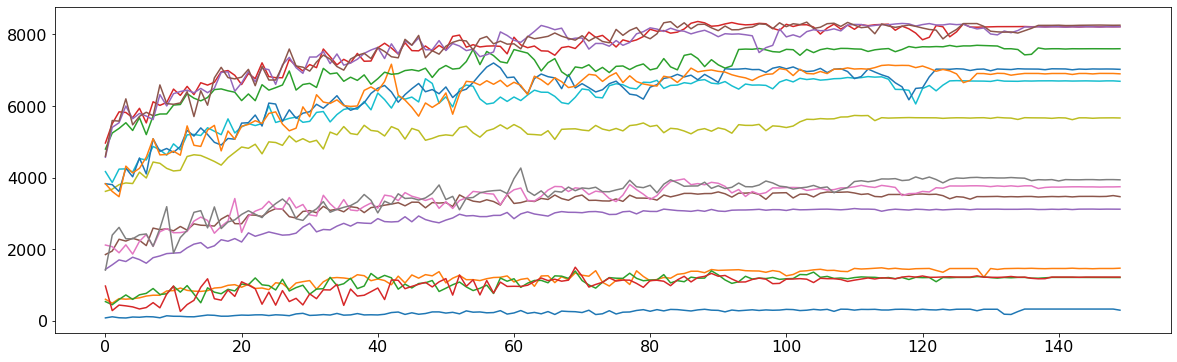

In [133]:
# reward plots
plt.figure(figsize = (20,6))
for i in range(len(reward_list)):
    plt.plot(reward_list[i])
plt.show()

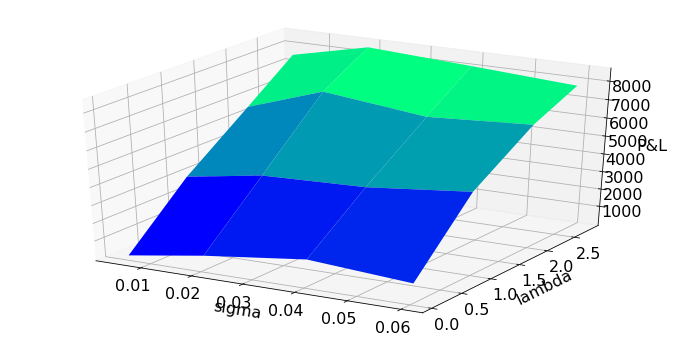

In [134]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection="3d")

y = np.array([0.05, 1.0, 2.0, 2.75])
x = np.array([0.005,0.02,0.04,0.06])

X, Y = np.meshgrid(x, y)
Z = [[],[],[],[]]
Z[0] = [pnl_list[i][2][0][-1] for i in range(4)]
Z[1] = [pnl_list[i][2][0][-1] for i in range(4,8)]
Z[2] = [pnl_list[i][2][0][-1] for i in range(8,12)]
Z[3] = [pnl_list[i][2][0][-1] for i in range(12,16)]
Z = np.array(Z)

ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.set_xlabel('sigma')
ax.set_ylabel('lambda')
ax.set_zlabel('P&L')

plt.show();

In [135]:
final_rewards = []
for i in [0.05, 1.0, 2.0, 2.75]:
    for j in [0.005, 0.02, 0.04, 0.06]:
        final_rewards.append([i,j])
for i in range(16):
    final_rewards[i].append(reward_list[i][-1])
def third(x):
    return x[2]
final_rewards.sort(key=third,reverse=True)
final_rewards

[[2.75, 0.06, 8258.900000000007],
 [2.75, 0.02, 8218.11999999999],
 [2.75, 0.04, 8215.450000000003],
 [2.75, 0.005, 7601.34999999999],
 [2.0, 0.04, 7025.212439024402],
 [2.0, 0.06, 6899.5269767441905],
 [2.0, 0.02, 6691.342631578942],
 [2.0, 0.005, 5665.64999999999],
 [1.0, 0.06, 3937.027322674414],
 [1.0, 0.04, 3743.6699999999923],
 [1.0, 0.02, 3465.975502392332],
 [1.0, 0.005, 3115.9499999999894],
 [0.05, 0.02, 1466.5428539983532],
 [0.05, 0.06, 1218.2399999999952],
 [0.05, 0.04, 1205.289999999995],
 [0.05, 0.005, 292.69999999999493]]

In [136]:
final_PnLs = []
for i in [0.05, 1.0, 2.0, 2.75]:
    for j in [0.005, 0.02, 0.04, 0.06]:
        final_PnLs.append([i,j])
for i in range(16):
    final_PnLs[i].append(pnl_list[i][2][0][-1])
def third(x):
    return x[2]
final_PnLs.sort(key=third,reverse=True)
final_PnLs

[[2.75, 0.02, 8527.199999999537],
 [2.75, 0.04, 8206.399999999541],
 [2.75, 0.06, 7862.549999999528],
 [2.75, 0.005, 7593.549999999671],
 [2.0, 0.02, 7051.999999999606],
 [2.0, 0.06, 6753.149999999521],
 [2.0, 0.04, 6421.949999999534],
 [2.0, 0.005, 5653.499999999669],
 [1.0, 0.06, 4547.849999999732],
 [1.0, 0.04, 3966.549999999751],
 [1.0, 0.02, 3789.249999999767],
 [1.0, 0.005, 3107.6499999997873],
 [0.05, 0.04, 1413.1999999998422],
 [0.05, 0.06, 1000.5999999998436],
 [0.05, 0.02, 715.9499999997973],
 [0.05, 0.005, 56.54999999999137]]

# Constant: Theta, Sigma
# Variable: Eta, lambda

In [113]:
def get_covariance(sigma: float, delta: float, theta: np.ndarray) -> np.ndarray:
    theta_p = theta + theta.T
    return (sigma ** 2.0) * inv(theta_p) * (np.eye(theta.shape[0]) - expm(-theta_p * delta))


def sample_gaussian(n: int, covariance: np.ndarray) -> np.ndarray:
    d, v = eig(covariance)
    a = np.dot(v, np.diag(np.sqrt(np.real(d))))
    g = np.random.normal(0.0, 1.0, (a.shape[0], n))
    return np.dot(a, g)


def sample_mean_reversion(n: int, x0: np.ndarray, mu: np.ndarray, sigma: float, delta: float,
                          theta: np.ndarray) -> np.ndarray:
    if not positive_eigenvalues(theta):
        raise AssertionError("Input theta does not have all positive eigenvalues")
    covariance = get_covariance(sigma, delta, theta)
    if not positive_eigenvalues(covariance):
        raise AssertionError("Covariance does not have all positive eigenvalues")
    gaussian_matrix = sample_gaussian(n, covariance)
    sample_paths = np.ndarray(gaussian_matrix.shape)
    sample_paths[:, [0]] = x0
    exp_theta = expm(-theta * delta)
    for i in range(1, sample_paths.shape[1]):
        prev = sample_paths[:, [i - 1]]
        sample_paths[:, [i]] = mu + np.dot(exp_theta, (prev - mu)) + gaussian_matrix[:, [i - 1]]
    return sample_paths


def positive_eigenvalues(theta: np.ndarray) -> bool:
    d, v = eig(theta)
    return np.all(np.real(d) > 0.0)


specs = pd.DataFrame(data={'p0': [100.0, 110.0, 150.0], # starting point                      
                           'mu': [100.0, 110.0, 80.0],  # mean                       
                           'theta': [0.05, 0.02, 0.0003],   # AR1 modal theta for yt = delta + (theta*yt-1) + Et
                           'sigma': [0.05, 0.02, 0.1],    # standard deviation
                           'lam': [0.05, 2.0, 0.05],    # bid-ask spread
                           'date': ['20200901', '20200909', '20200916']},
                     index=[1, 2, 3])

def generate_data(lmbd):
    episode = 2
    train = False
    episode_specs = specs.loc[episode]
    date = episode_specs.date
    file_name = 'sample_data_' + date + '_' + str(episode) + ('_train.csv' if train else '_mytest.csv')
    seed = 0
    p0 = episode_specs['p0']  # 100.0, 110.0
    mu = episode_specs['mu']  # 100.0, 110.0
    theta = 0.035
    sigma = 0.035
    n = 36_000
    display = 30_000
    lam = lmbd
    resolution = 1.0 / 10.0  # per dollar
    q_min = 50.0
    q_max = 100.0

    np.random.seed(seed)
    default_font_size = 16
    model_type = 'tree'  # it can be 'tree' or 'nn'

    gaussian_vector = np.random.normal(0.0, 1.0, 2 * n)
    poisson_vector = 1 + np.random.poisson(lam, 2 * n)
    quantities = np.round(np.random.uniform(size=(2 * n, 2)) * (q_max - q_min) + q_min)
    mid = np.ndarray(2 * n)
    p = p0
    for i in range(2 * n):
        pm1 = p0 if i == 0 else mid[i - 1]
        mid[i] = pm1 + np.floor((theta * (mu - pm1) + sigma * gaussian_vector[i]) / resolution + 0.5) * resolution
    spread = resolution * poisson_vector
    order_books = pd.DataFrame(data={'bidPrice': mid - 0.5 * spread, 'offerPrice': mid + 0.5 * spread,
                                     'bidQty': quantities[:, 0], 'offerQty': quantities[:, 1]})
    order_books.index.name = 'time'
    order_books = order_books.iloc[:n] if train else order_books.iloc[n:]

    formats = {'bidPrice': '{:.2f}', 'offerPrice': '{:.2f}', 'bidQty': '{:.0f}', 'offerQty': '{:.0f}'}
    for col, f in formats.items():
        order_books[col] = order_books[col].map(lambda x: f.format(x))
    order_books.to_csv(file_name, float_format='%.3f')

In [114]:
reward_list = []
pnl_list = []
action_list = []

for L in [0.05, 1.0, 2.0, 2.75]:
    for etaa in [0.05, 0.27, 0.48, 0.7, 0.92]:
        
        epsilon = 0.9
        alpha, gamma = 0.1, 0.9
        eta = etaa
        
        generate_data(L)
        
        MM_train = pd.read_csv('noise_trades__train.csv', index_col = 0)
        week1 = pd.read_csv('sample_data_20200909_2_mytest.csv', index_col = 0)
        MM_train['trade'] = 0
        MM_train['trade'] = -1*(MM_train['side'] == 'SELL') + 1*(MM_train['side'] == 'BUY')
        MM_train['qty'].fillna(0,inplace= True)
        trd = MM_train['trade']
        qyt = MM_train['qty']
        trdqyt = [trd[i]*qyt[i] for i in range(len(trd))]
        week1['trade'] = trdqyt
        week1['midPrice'] = (week1['bidPrice'] + week1['offerPrice'])/2
        data_ = week1.loc[week1['trade']!=0, :].copy()
        
        Q_table = np.zeros((len(ParamSpace['state_space']), len(ParamSpace['A_space'])))

        r = []
        action_list = []
        t1 = perf_counter()
        for ep in range(175):
            actions = []
            env = MakerGame(data_)
            state = env.inventory
            rewards_for_one_ep = []
            pnls_for_one_ep = []
            for i in range(len(data_)-1):
                state = 10*int(state / 10)
                act = choose_action(state)
                actions.append(act)
                next_state, reward, pnl, done = env.step(act)
                next_state = 10*int(next_state / 10)
                rewards_for_one_ep.append(reward)
                pnls_for_one_ep.append(pnl)
                q_sa = Q_table[np.where(ParamSpace['state_space'] == state)[0], act]
                maxQ = np.max(Q_table[np.where(ParamSpace['state_space'] == next_state)[0], :])
                increment = alpha * (reward + gamma * maxQ - q_sa)
                Q_table[np.where(ParamSpace['state_space'] == state)[0], act] = q_sa + increment
                state = next_state

            epsilon *= 0.95
            r.append(sum(rewards_for_one_ep))
            action_list.append(actions)
        
        t2 = perf_counter()
        print("FINISHED. TIME ELAPSED: {} seconds".format(t2-t1))
        reward_list.append(r)
        
        action = action_list[-1]
        bid_spread, ask_spread, clear = [], [], []
        for i in range(len(action)):
            if action[i] == 9:
                bid_spread.append(0)
                ask_spread.append(0)
                clear.append(True)
            else:
                bid_spread.append(action_space[action[i]][0])
                ask_spread.append(action_space[action[i]][1])
                clear.append(False)
        
        data_ = data_.iloc[:len(bid_spread),:]
        bids = list(data_['midPrice'] - np.array(bid_spread))
        asks = list(data_['midPrice'] + np.array(ask_spread))
        pnl_list.append([L,etaa,PnL_for_MM(data_, bids, asks, clear)])
        action_list.append(action)
        print(pnl_list[-1][0],pnl_list[-1][1],pnl_list[-1][2][0][-1])

FINISHED. TIME ELAPSED: 69.05160001299737 seconds
0.05 0.05 38.54999999999821
FINISHED. TIME ELAPSED: 65.33211455499986 seconds
0.05 0.27 -3.9000000000020663
FINISHED. TIME ELAPSED: 66.05266229699919 seconds
0.05 0.48 663.375862068873
FINISHED. TIME ELAPSED: 69.26082016199871 seconds
0.05 0.7 1420.899999999848
FINISHED. TIME ELAPSED: 70.00290034799764 seconds
0.05 0.92 1280.7499999998354
FINISHED. TIME ELAPSED: 77.19913308000105 seconds
1.0 0.05 3842.7499999997176
FINISHED. TIME ELAPSED: 77.44086880900068 seconds
1.0 0.27 3531.4499999997597
FINISHED. TIME ELAPSED: 80.7522964689997 seconds
1.0 0.48 4067.699999999729
FINISHED. TIME ELAPSED: 82.67530769600125 seconds
1.0 0.7 4075.4499999997365
FINISHED. TIME ELAPSED: 83.88777837300222 seconds
1.0 0.92 4026.899999999755
FINISHED. TIME ELAPSED: 115.66110845399817 seconds
2.0 0.05 6774.049999999609
FINISHED. TIME ELAPSED: 112.81258326399984 seconds
2.0 0.27 6935.399999999591
FINISHED. TIME ELAPSED: 116.22424134000175 seconds
2.0 0.48 7224.79

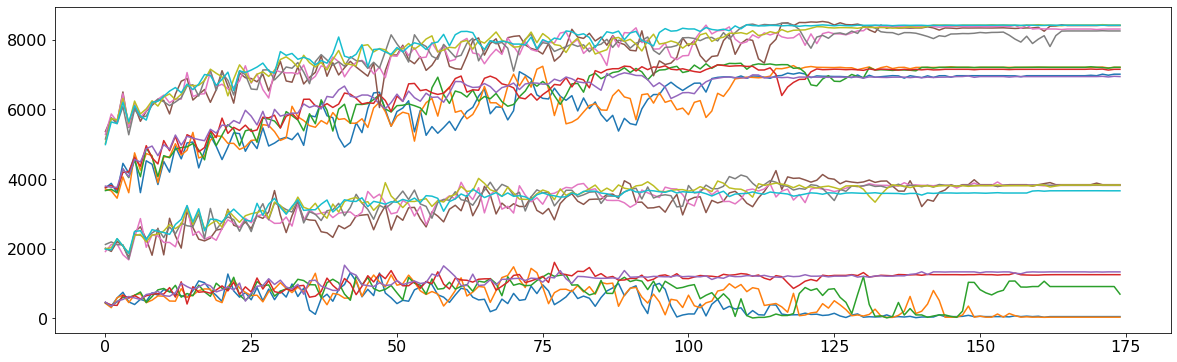

In [115]:
plt.figure(figsize = (20,6))
for i in range(len(reward_list)):
    plt.plot(reward_list[i])
plt.show()

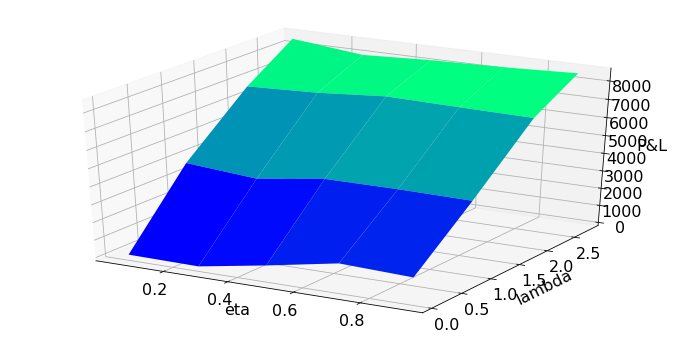

In [120]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection="3d")

y = np.array([0.05, 1.0, 2.0, 2.75])
x = np.array([0.05, 0.27, 0.48, 0.7, 0.92])

X, Y = np.meshgrid(x, y)
Z = [[],[],[],[]]
Z[0] = [pnl_list[i][2][0][-1] for i in range(5)]
Z[1] = [pnl_list[i][2][0][-1] for i in range(5,10)]
Z[2] = [pnl_list[i][2][0][-1] for i in range(10,15)]
Z[3] = [pnl_list[i][2][0][-1] for i in range(15,20)]
Z = np.array(Z)


ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.set_xlabel('eta')
ax.set_ylabel('lambda')
ax.set_zlabel('P&L')

plt.show();

In [118]:
final_rewards = []
for i in y:
    for j in x:
        final_rewards.append([i,j])
for i in range(20):
    final_rewards[i].append(reward_list[i][-1])
def third(x):
    return x[2]
final_rewards.sort(key=third,reverse=True)
final_rewards

[[2.75, 0.7, 8422.92999999999],
 [2.75, 0.92, 8418.626],
 [2.75, 0.05, 8409.420000000016],
 [2.75, 0.27, 8309.962999999996],
 [2.75, 0.48, 8255.229999999992],
 [2.0, 0.48, 7211.237999999981],
 [2.0, 0.27, 7211.046999999972],
 [2.0, 0.7, 7153.499999999975],
 [2.0, 0.05, 7013.594999999966],
 [2.0, 0.92, 6945.0979999999945],
 [1.0, 0.05, 3840.7599999999343],
 [1.0, 0.7, 3830.299999999977],
 [1.0, 0.27, 3822.142522777573],
 [1.0, 0.48, 3821.663999999972],
 [1.0, 0.92, 3665.27999999999],
 [0.05, 0.92, 1337.1112498163457],
 [0.05, 0.7, 1256.8637794129152],
 [0.05, 0.48, 698.1622300241926],
 [0.05, 0.05, 52.86500000000061],
 [0.05, 0.27, 36.33799999999957]]

In [119]:
final_PnLs = []
for i in y:
    for j in x:
        final_PnLs.append([i,j])
for i in range(20):
    final_PnLs[i].append(pnl_list[i][2][0][-1])
def third(x):
    return x[2]
final_PnLs.sort(key=third,reverse=True)
final_PnLs

[[2.75, 0.92, 8521.549999999477],
 [2.75, 0.05, 8472.049999999694],
 [2.75, 0.7, 8352.999999999663],
 [2.75, 0.48, 8244.649999999807],
 [2.75, 0.27, 8065.099999999811],
 [2.0, 0.48, 7224.79999999956],
 [2.0, 0.7, 7154.9499999995405],
 [2.0, 0.92, 7102.1499999995485],
 [2.0, 0.27, 6935.399999999591],
 [2.0, 0.05, 6774.049999999609],
 [1.0, 0.7, 4075.4499999997365],
 [1.0, 0.48, 4067.699999999729],
 [1.0, 0.92, 4026.899999999755],
 [1.0, 0.05, 3842.7499999997176],
 [1.0, 0.27, 3531.4499999997597],
 [0.05, 0.7, 1420.899999999848],
 [0.05, 0.92, 1280.7499999998354],
 [0.05, 0.48, 663.375862068873],
 [0.05, 0.05, 38.54999999999821],
 [0.05, 0.27, -3.9000000000020663]]

# Where RL did not work
# Low theta=0.0003, higher sigma=0.1, higher lambda=0.15
# variable eta

In [253]:
reward_list = []
pnl_list_is = []
pnl_list_os = []
action_list = []

for etaa in np.arange(0,1.01,0.1):

    epsilon = 0.9
    alpha, gamma = 0.1, 0.9
    eta = etaa

    MM_train = pd.read_csv('noise_trades__train.csv', index_col = 0)
    week1 = pd.read_csv('sample_data_20200916_3_train.csv', index_col = 0)
    MM_train['trade'] = 0
    MM_train['trade'] = -1*(MM_train['side'] == 'SELL') + 1*(MM_train['side'] == 'BUY')
    MM_train['qty'].fillna(0,inplace= True)
    trd = MM_train['trade']
    qyt = MM_train['qty']
    trdqyt = [trd[i]*qyt[i] for i in range(len(trd))]
    week1['trade'] = trdqyt
    week1['midPrice'] = (week1['bidPrice'] + week1['offerPrice'])/2
    data_ = week1.loc[week1['trade']!=0, :].copy()

    Q_table = np.zeros((len(ParamSpace['state_space']), len(ParamSpace['A_space'])))

    r = []
    action_list = []
    t1 = perf_counter()
    for ep in range(165):
        actions = []
        env = MakerGame(data_)
        state = env.inventory
        rewards_for_one_ep = []
        pnls_for_one_ep = []
        for i in range(len(data_)-1):
            state = 10*int(state / 10)
            act = choose_action(state)
            actions.append(act)
            next_state, reward, pnl, done = env.step(act)
            next_state = 10*int(next_state / 10)
            rewards_for_one_ep.append(reward)
            pnls_for_one_ep.append(pnl)
            q_sa = Q_table[np.where(ParamSpace['state_space'] == state)[0], act]
            maxQ = np.max(Q_table[np.where(ParamSpace['state_space'] == next_state)[0], :])
            increment = alpha * (reward + gamma * maxQ - q_sa)
            Q_table[np.where(ParamSpace['state_space'] == state)[0], act] = q_sa + increment
            state = next_state

        epsilon *= 0.95
        r.append(sum(rewards_for_one_ep))
        action_list.append(actions)

    t2 = perf_counter()
    print("FINISHED. TIME ELAPSED: {} seconds".format(t2-t1))
    reward_list.append(r)
    
    action = action_list[-1]
    bid_spread, ask_spread, clear = [], [], []
    for i in range(len(action)):
        if action[i] == 9:
            bid_spread.append(0)
            ask_spread.append(0)
            clear.append(True)
        else:
            bid_spread.append(action_space[action[i]][0])
            ask_spread.append(action_space[action[i]][1])
            clear.append(False)

    data_ = data_.iloc[:len(bid_spread),:]
    bids = list(data_['midPrice'] - np.array(bid_spread))
    asks = list(data_['midPrice'] + np.array(ask_spread))
    pnl_list_is.append([etaa,PnL_for_MM(data_, bids, asks, clear)])
    action_list.append(action)
    print(etaa,pnl_list_is[-1][1][0][-1])

    MM_train = pd.read_csv('noise_trades__train.csv', index_col = 0)
    week1 = pd.read_csv('sample_data_20200916_3_test.csv', index_col = 0)

    MM_train['trade'] = 0
    MM_train['trade'] = -1*(MM_train['side'] == 'SELL') + 1*(MM_train['side'] == 'BUY')
    MM_train['qty'].fillna(0,inplace= True)
    t = list(MM_train['trade'])
    q = list(MM_train['qty'])
    tq = [t[i]*q[i] for i in range(36000)]
    week1['trade'] = tq
    week1['midPrice'] = (week1['bidPrice'] + week1['offerPrice'])/2

    data_ = week1.loc[week1['trade']!=0, :].copy()
    
    actions = []
    env = MakerGame(data_)
    state = env.inventory
    pnl_oos = []
    for i in range(len(data_)-1):
        state = 10*int(state / 10)
        act = choose_action(state)
        actions.append(act)
        next_state, reward, pnl, done = env.step(act)
        next_state = 10*int(next_state / 10)
        pnl_oos.append(pnl)
        state = next_state
    
    bid_spread, ask_spread, clear = [], [], []
    for i in range(len(actions)):
        if actions[i] == 9:
            bid_spread.append(0)
            ask_spread.append(0)
            clear.append(True)
        else:
            bid_spread.append(action_space[actions[i]][0])
            ask_spread.append(action_space[actions[i]][1])
            clear.append(False)
    data_ = data_.iloc[:len(bid_spread),:]
    bids = list(data_['midPrice'] - np.array(bid_spread))
    asks = list(data_['midPrice'] + np.array(ask_spread))
    pnl_list_os.append([etaa,PnL_for_MM(data_, bids, asks, clear)])
    print(etaa,pnl_list_os[-1][1][0][-1])

FINISHED. TIME ELAPSED: 57.4367994320055 seconds
0.0 0.0
0.0 0.0
FINISHED. TIME ELAPSED: 92.56354914599797 seconds
0.1 0.0
0.1 0.0
FINISHED. TIME ELAPSED: 119.02963330199418 seconds
0.2 1001.8999999999892
0.2 672.2999999999856
FINISHED. TIME ELAPSED: 104.77430181500677 seconds
0.30000000000000004 -1175.5499999999997
0.30000000000000004 -69.5000000000036
FINISHED. TIME ELAPSED: 90.76629339899955 seconds
0.4 0.0
0.4 0.0
FINISHED. TIME ELAPSED: 87.7287561530029 seconds
0.5 -3120.049999999999
0.5 451.0499999999787
FINISHED. TIME ELAPSED: 94.07488147600088 seconds
0.6000000000000001 -2372.750000000003
0.6000000000000001 -2.9000000000048374
FINISHED. TIME ELAPSED: 82.24785557299765 seconds
0.7000000000000001 -4210.200000000001
0.7000000000000001 344.7499999999991
FINISHED. TIME ELAPSED: 102.81173478999699 seconds
0.8 1031.643478260721
0.8 1922.099999999854
FINISHED. TIME ELAPSED: 104.01523345299938 seconds
0.9 -397.7000000001748
0.9 2275.299999999825
FINISHED. TIME ELAPSED: 102.0065865729993

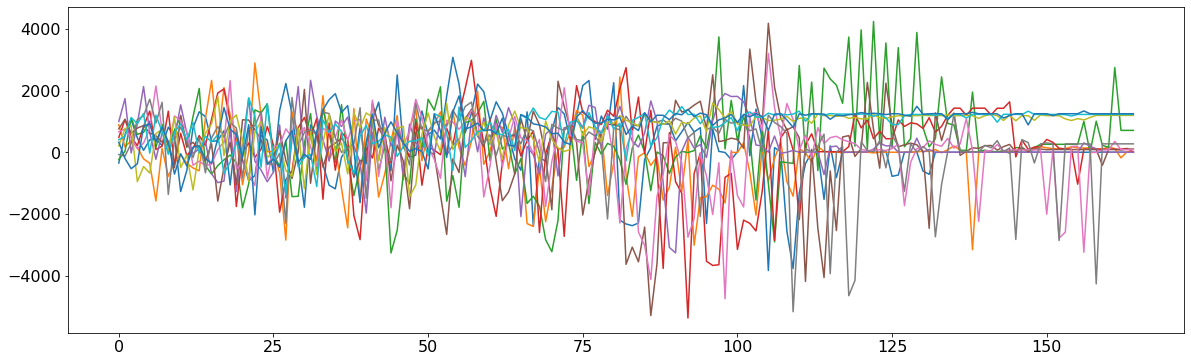

In [254]:
plt.figure(figsize = (20,6))
for i in range(len(reward_list)):
    plt.plot(reward_list[i])
plt.show()

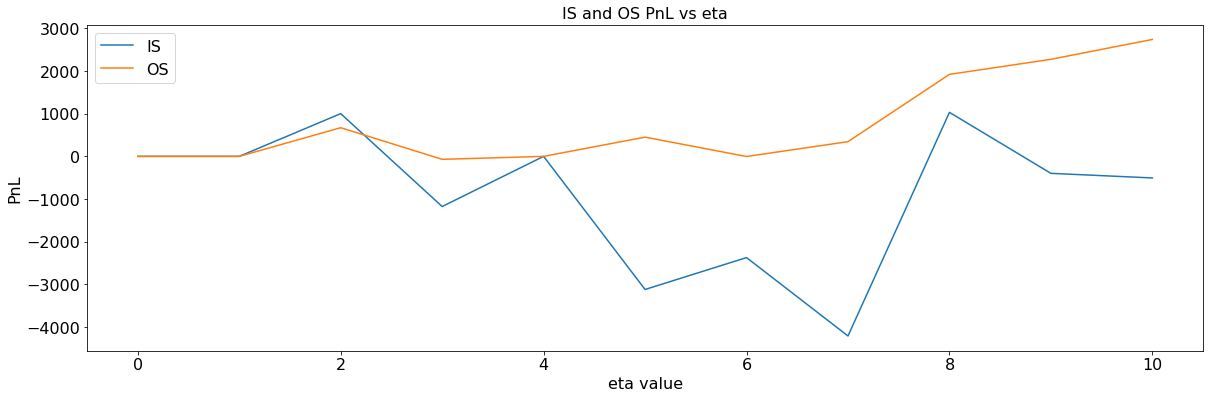

In [256]:
ispnl = [pnl_list_is[i][1][0][-1] for i in range(len(pnl_list_is))]
ospnl = [pnl_list_os[i][1][0][-1] for i in range(len(pnl_list_os))]
plt.figure(figsize = (20,6))
plt.plot(ispnl)
plt.plot(ospnl)
plt.legend(['IS','OS'])
plt.ylabel('PnL')
plt.xlabel('eta value')
plt.title('IS and OS PnL vs eta');

# Price Plots

In [195]:
def get_covariance(sigma: float, delta: float, theta: np.ndarray) -> np.ndarray:
    theta_p = theta + theta.T
    return (sigma ** 2.0) * inv(theta_p) * (np.eye(theta.shape[0]) - expm(-theta_p * delta))


def sample_gaussian(n: int, covariance: np.ndarray) -> np.ndarray:
    d, v = eig(covariance)
    a = np.dot(v, np.diag(np.sqrt(np.real(d))))
    g = np.random.normal(0.0, 1.0, (a.shape[0], n))
    return np.dot(a, g)


def sample_mean_reversion(n: int, x0: np.ndarray, mu: np.ndarray, sigma: float, delta: float,
                          theta: np.ndarray) -> np.ndarray:
    if not positive_eigenvalues(theta):
        raise AssertionError("Input theta does not have all positive eigenvalues")
    covariance = get_covariance(sigma, delta, theta)
    if not positive_eigenvalues(covariance):
        raise AssertionError("Covariance does not have all positive eigenvalues")
    gaussian_matrix = sample_gaussian(n, covariance)
    sample_paths = np.ndarray(gaussian_matrix.shape)
    sample_paths[:, [0]] = x0
    exp_theta = expm(-theta * delta)
    for i in range(1, sample_paths.shape[1]):
        prev = sample_paths[:, [i - 1]]
        sample_paths[:, [i]] = mu + np.dot(exp_theta, (prev - mu)) + gaussian_matrix[:, [i - 1]]
    return sample_paths


def positive_eigenvalues(theta: np.ndarray) -> bool:
    d, v = eig(theta)
    return np.all(np.real(d) > 0.0)


specs = pd.DataFrame(data={'p0': [100.0, 110.0, 150.0], # starting point                      
                           'mu': [100.0, 110.0, 80.0],  # mean                       
                           'theta': [0.05, 0.02, 0.0003],   # AR1 modal theta for yt = delta + (theta*yt-1) + Et
                           'sigma': [0.05, 0.02, 0.1],    # standard deviation
                           'lam': [0.05, 2.0, 0.05],    # bid-ask spread
                           'date': ['20200901', '20200909', '20200916']},
                     index=[1, 2, 3])

def plot_data(lmbd,sig,thet):
    episode = 2
    train = False
    episode_specs = specs.loc[episode]
    date = episode_specs.date
    file_name = 'sample_data_' + date + '_' + str(episode) + ('_train.csv' if train else '_mytest.csv')
    seed = 0
    p0 = episode_specs['p0']  # 100.0, 110.0
    mu = episode_specs['mu']  # 100.0, 110.0
    theta = thet
    sigma = sig
    n = 1_250
    display = 30_000
    lam = lmbd
    resolution = 1.0 / 10.0  # per dollar
    q_min = 50.0
    q_max = 100.0

    np.random.seed(seed)
    default_font_size = 16
    model_type = 'tree'  # it can be 'tree' or 'nn'

    gaussian_vector = np.random.normal(0.0, 1.0, 2 * n)
    poisson_vector = 1 + np.random.poisson(lam, 2 * n)
    quantities = np.round(np.random.uniform(size=(2 * n, 2)) * (q_max - q_min) + q_min)
    mid = np.ndarray(2 * n)
    p = p0
    for i in range(2 * n):
        pm1 = p0 if i == 0 else mid[i - 1]
        mid[i] = pm1 + np.floor((theta * (mu - pm1) + sigma * gaussian_vector[i]) / resolution + 0.5) * resolution
    spread = resolution * poisson_vector
    order_books = pd.DataFrame(data={'bidPrice': mid - 0.5 * spread, 'offerPrice': mid + 0.5 * spread,
                                     'bidQty': quantities[:, 0], 'offerQty': quantities[:, 1]})
    order_books.index.name = 'time'
    order_books = order_books.iloc[:n] if train else order_books.iloc[n:]

    formats = {'bidPrice': '{:.2f}', 'offerPrice': '{:.2f}', 'bidQty': '{:.0f}', 'offerQty': '{:.0f}'}
    for col, f in formats.items():
        order_books[col] = order_books[col].map(lambda x: f.format(x))
    order_books.to_csv(file_name, float_format='%.3f')

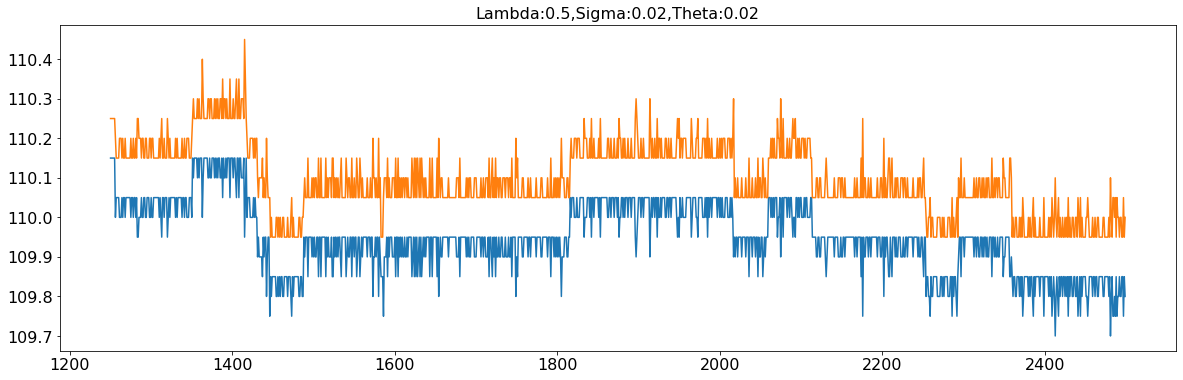

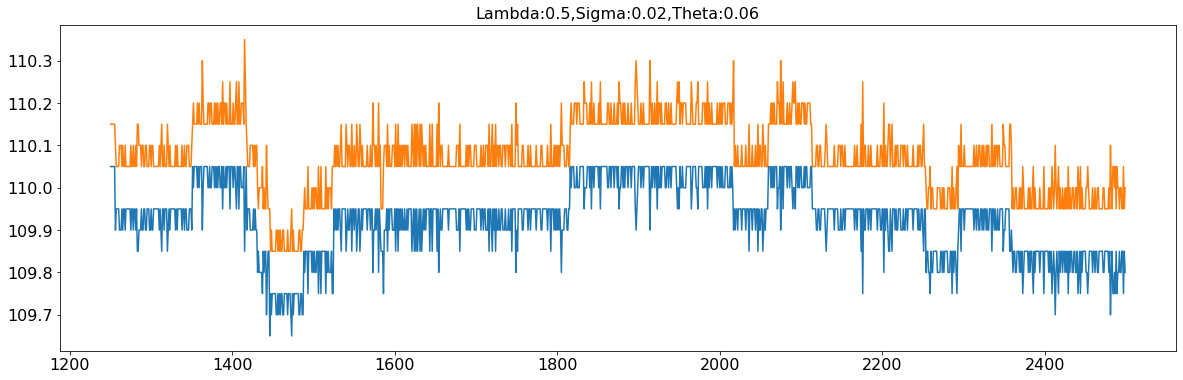

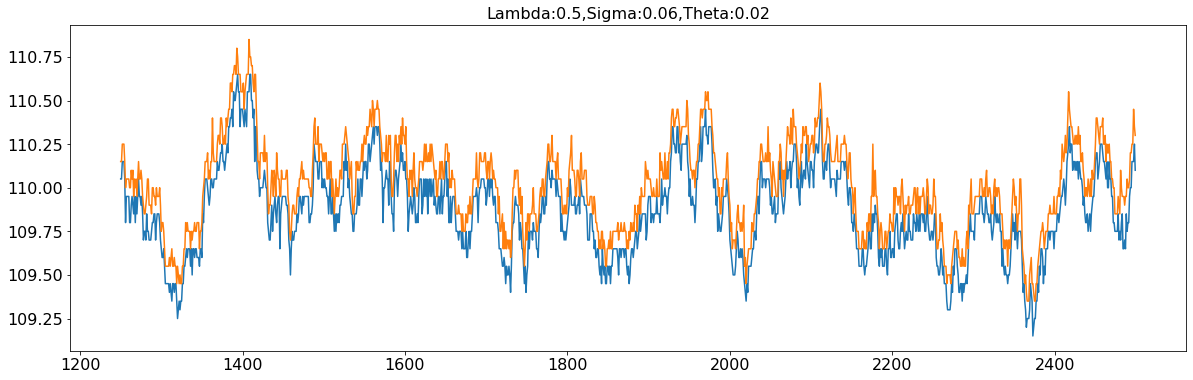

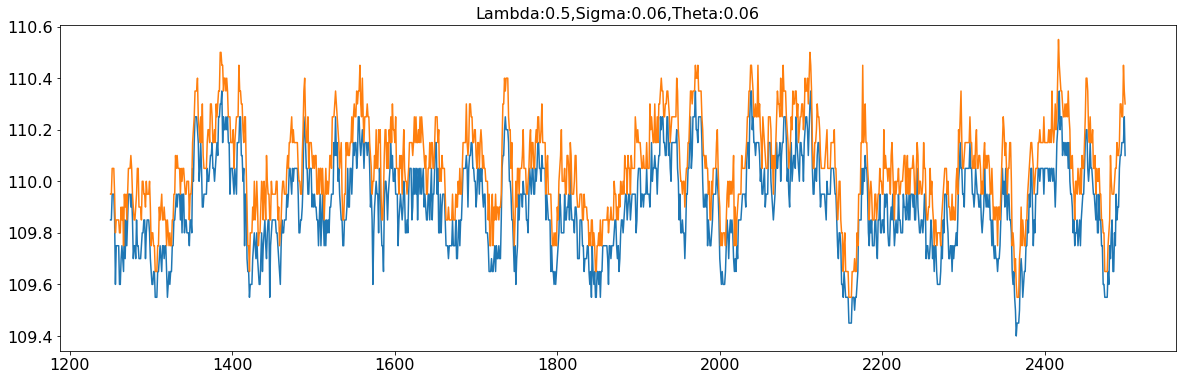

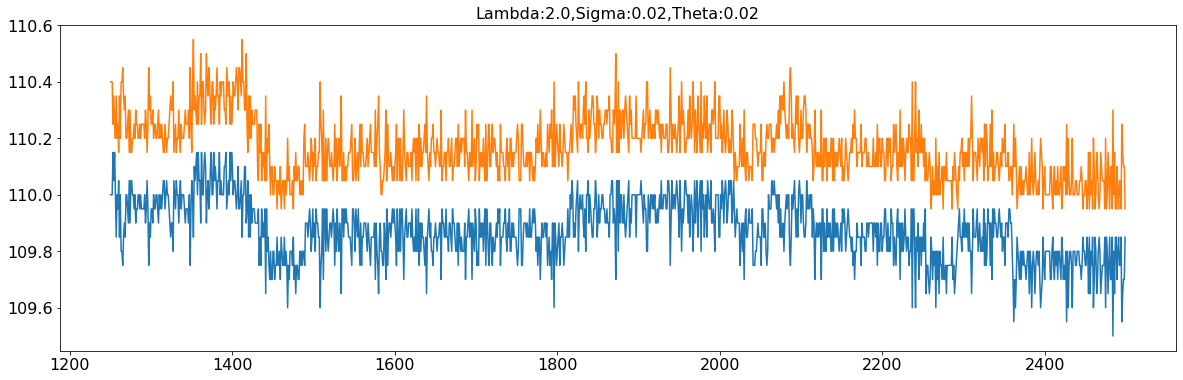

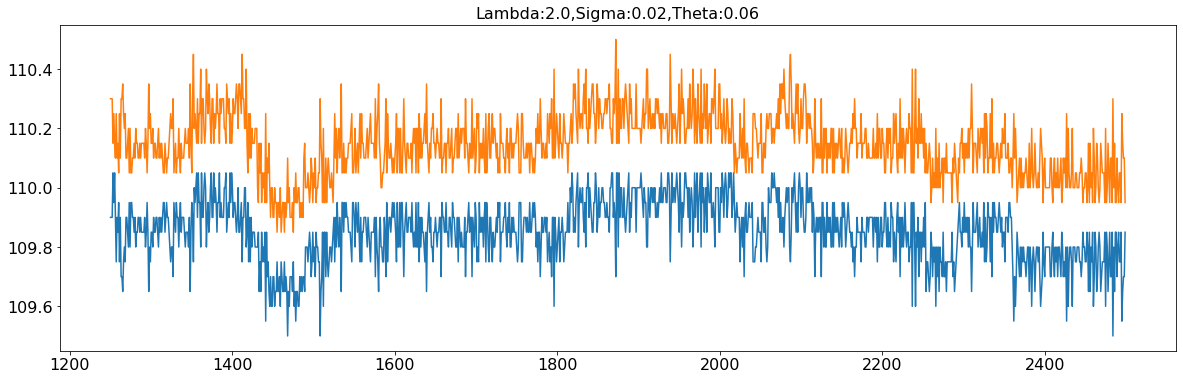

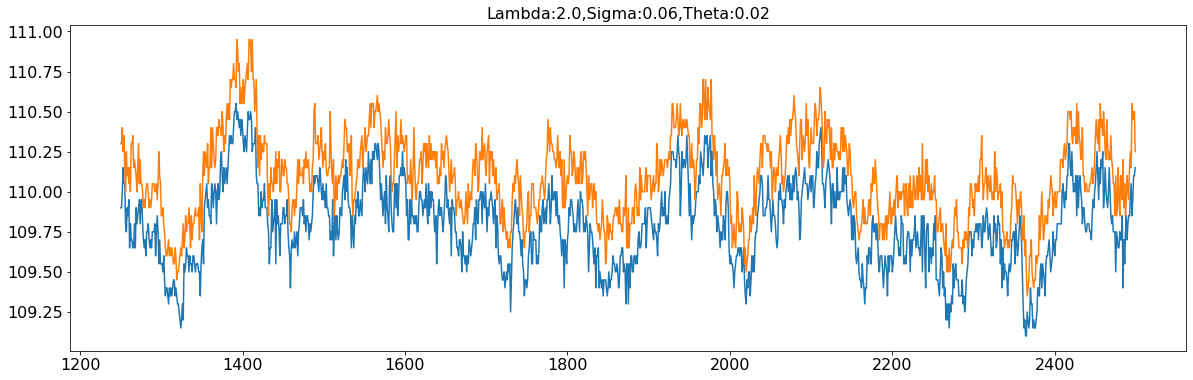

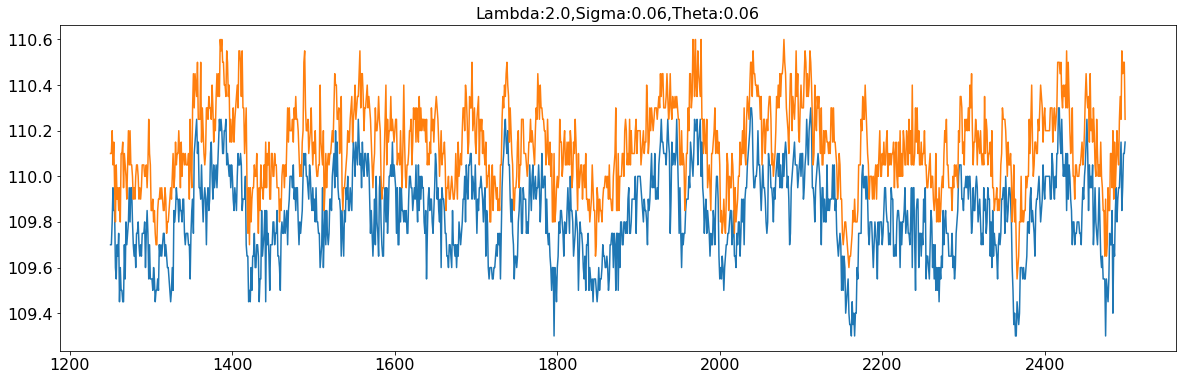

In [196]:
reward_list = []
pnl_list = []
action_list = []

for L in [0.5, 2.0]:
    for S in [0.02, 0.06]:
        for T in [0.02, 0.06]:
        
            epsilon = 0.9
            alpha, gamma = 0.1, 0.9

            plot_data(L,S,T)

            week1 = pd.read_csv('sample_data_20200909_2_mytest.csv', index_col = 0)
            week1['midPrice'] = (week1['bidPrice'] + week1['offerPrice'])/2
            plt.figure(figsize = (20,6))
            plt.plot(week1['bidPrice'])
            plt.plot(week1['offerPrice'])
            plt.title('Lambda:'+str(L)+','+'Sigma:'+str(S)+','+'Theta:'+str(T))
            plt.show();